# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

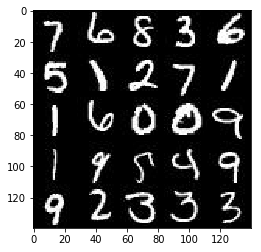

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

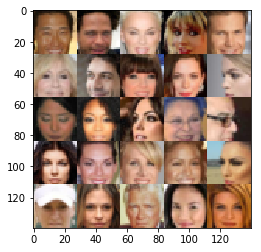

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, is_train=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Inputs 28x28x3
        
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        # no batchnorm for first conv layer
        x1 = tf.maximum(alpha*x1, x1)
        # Layer output 14x14x64
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # Layer output 7x7x128
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # Layer output 4x4x128
        
        # Flattening
        f = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(f, 1) # one output neuron for binary classification
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # took me days to figure out that function needs to maintain 3 positional params
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected layer and reshaping
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # Layer output 7x7x256
        
        # Conv layer
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # Layer output 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        # Output 28x28x3
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    
    d_real_model, d_real_logits = discriminator(input_real)
    d_fake_model, d_fake_logits = discriminator(g_model, reuse=True)
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_real_logits, labels=tf.ones_like(d_real_model) * (1-smooth)))
    
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits, labels=tf.zeros_like(d_fake_model)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits, labels=tf.ones_like(d_fake_model)))
    
    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    image_channels = 3 if data_image_mode=='RGB' else 1
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = -1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                # creating noise input for generator 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # normalizing image inputs
                batch_images *= 2
                
                # running D optimizer
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                
                # running G optimizer twice for better performance
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # displaying training losses
                    t_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    t_loss_g = g_loss.eval({z_input: batch_z})
                    print('**********************************')
                    print('Step: {}'.format(steps+1))
                    print('Epoch: {}/{}'.format(epoch_i+1, epoch_count))
                    print('D Loss: {:.4f}'.format(t_loss_d))
                    print('G Loss: {:.4f}'.format(t_loss_g))
                    
                    # displaying a sample of generated images
                    if steps % 100 == 0: 
                        print('**********************************')
                        show_generator_output(sess, batch_size, z_input, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

**********************************
Step: 1
Epoch: 1/2
D Loss: 7.2613
G Loss: 0.0027
**********************************


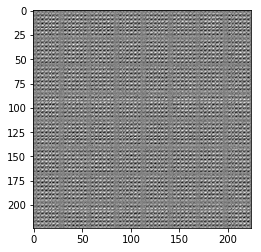

**********************************
Step: 11
Epoch: 1/2
D Loss: 1.1687
G Loss: 3.3744
**********************************
Step: 21
Epoch: 1/2
D Loss: 3.2479
G Loss: 0.0852
**********************************
Step: 31
Epoch: 1/2
D Loss: 2.2428
G Loss: 0.4325
**********************************
Step: 41
Epoch: 1/2
D Loss: 2.5220
G Loss: 0.1423
**********************************
Step: 51
Epoch: 1/2
D Loss: 2.3074
G Loss: 0.2165
**********************************
Step: 61
Epoch: 1/2
D Loss: 2.3103
G Loss: 0.1878
**********************************
Step: 71
Epoch: 1/2
D Loss: 2.1523
G Loss: 0.2085
**********************************
Step: 81
Epoch: 1/2
D Loss: 2.2203
G Loss: 0.2057
**********************************
Step: 91
Epoch: 1/2
D Loss: 1.7942
G Loss: 0.5145
**********************************
Step: 101
Epoch: 1/2
D Loss: 1.9291
G Loss: 0.2687
**********************************


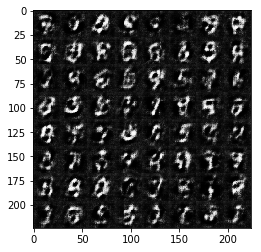

**********************************
Step: 111
Epoch: 1/2
D Loss: 2.0976
G Loss: 0.2076
**********************************
Step: 121
Epoch: 1/2
D Loss: 1.8247
G Loss: 0.6855
**********************************
Step: 131
Epoch: 1/2
D Loss: 1.6941
G Loss: 0.3744
**********************************
Step: 141
Epoch: 1/2
D Loss: 1.5570
G Loss: 0.5375
**********************************
Step: 151
Epoch: 1/2
D Loss: 1.6330
G Loss: 0.5495
**********************************
Step: 161
Epoch: 1/2
D Loss: 2.4758
G Loss: 0.1377
**********************************
Step: 171
Epoch: 1/2
D Loss: 1.9500
G Loss: 0.2619
**********************************
Step: 181
Epoch: 1/2
D Loss: 1.5649
G Loss: 0.6659
**********************************
Step: 191
Epoch: 1/2
D Loss: 1.8442
G Loss: 0.2915
**********************************
Step: 201
Epoch: 1/2
D Loss: 1.4991
G Loss: 0.6351
**********************************


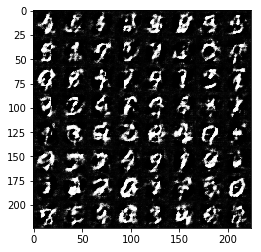

**********************************
Step: 211
Epoch: 1/2
D Loss: 2.7148
G Loss: 0.1120
**********************************
Step: 221
Epoch: 1/2
D Loss: 1.5588
G Loss: 0.6873
**********************************
Step: 231
Epoch: 1/2
D Loss: 1.7657
G Loss: 0.3698
**********************************
Step: 241
Epoch: 1/2
D Loss: 2.0611
G Loss: 0.2235
**********************************
Step: 251
Epoch: 1/2
D Loss: 1.4925
G Loss: 0.8323
**********************************
Step: 261
Epoch: 1/2
D Loss: 1.5510
G Loss: 0.4763
**********************************
Step: 271
Epoch: 1/2
D Loss: 1.7880
G Loss: 0.4378
**********************************
Step: 281
Epoch: 1/2
D Loss: 1.5601
G Loss: 0.8036
**********************************
Step: 291
Epoch: 1/2
D Loss: 2.6435
G Loss: 0.1193
**********************************
Step: 301
Epoch: 1/2
D Loss: 1.8587
G Loss: 0.3303
**********************************


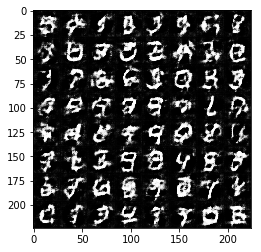

**********************************
Step: 311
Epoch: 1/2
D Loss: 2.4611
G Loss: 0.1496
**********************************
Step: 321
Epoch: 1/2
D Loss: 2.3809
G Loss: 0.1591
**********************************
Step: 331
Epoch: 1/2
D Loss: 1.9108
G Loss: 0.2692
**********************************
Step: 341
Epoch: 1/2
D Loss: 1.8807
G Loss: 0.3001
**********************************
Step: 351
Epoch: 1/2
D Loss: 1.7019
G Loss: 1.5163
**********************************
Step: 361
Epoch: 1/2
D Loss: 2.0947
G Loss: 0.2225
**********************************
Step: 371
Epoch: 1/2
D Loss: 2.3067
G Loss: 0.1816
**********************************
Step: 381
Epoch: 1/2
D Loss: 1.4599
G Loss: 0.8966
**********************************
Step: 391
Epoch: 1/2
D Loss: 1.5151
G Loss: 0.9077
**********************************
Step: 401
Epoch: 1/2
D Loss: 2.1276
G Loss: 0.2277
**********************************


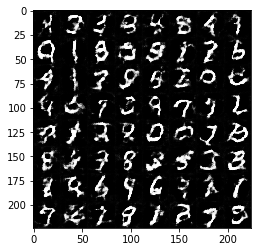

**********************************
Step: 411
Epoch: 1/2
D Loss: 1.9819
G Loss: 0.2581
**********************************
Step: 421
Epoch: 1/2
D Loss: 2.3985
G Loss: 0.1685
**********************************
Step: 431
Epoch: 1/2
D Loss: 1.6278
G Loss: 0.5022
**********************************
Step: 441
Epoch: 1/2
D Loss: 2.4289
G Loss: 0.1535
**********************************
Step: 451
Epoch: 1/2
D Loss: 1.8375
G Loss: 0.3015
**********************************
Step: 461
Epoch: 1/2
D Loss: 1.5041
G Loss: 0.7632
**********************************
Step: 471
Epoch: 1/2
D Loss: 1.7223
G Loss: 0.3591
**********************************
Step: 481
Epoch: 1/2
D Loss: 1.6823
G Loss: 0.4452
**********************************
Step: 491
Epoch: 1/2
D Loss: 2.3257
G Loss: 2.0026
**********************************
Step: 501
Epoch: 1/2
D Loss: 1.4040
G Loss: 0.6196
**********************************


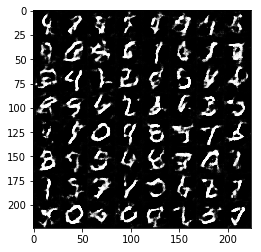

**********************************
Step: 511
Epoch: 1/2
D Loss: 1.4346
G Loss: 0.6350
**********************************
Step: 521
Epoch: 1/2
D Loss: 1.5504
G Loss: 0.5930
**********************************
Step: 531
Epoch: 1/2
D Loss: 1.7830
G Loss: 0.3364
**********************************
Step: 541
Epoch: 1/2
D Loss: 1.5426
G Loss: 0.6367
**********************************
Step: 551
Epoch: 1/2
D Loss: 1.7910
G Loss: 0.5420
**********************************
Step: 561
Epoch: 1/2
D Loss: 1.6686
G Loss: 0.4157
**********************************
Step: 571
Epoch: 1/2
D Loss: 1.9565
G Loss: 0.2659
**********************************
Step: 581
Epoch: 1/2
D Loss: 1.8858
G Loss: 0.3080
**********************************
Step: 591
Epoch: 1/2
D Loss: 1.8912
G Loss: 0.2784
**********************************
Step: 601
Epoch: 1/2
D Loss: 3.7785
G Loss: 0.0491
**********************************


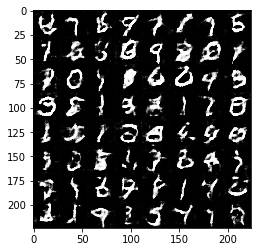

**********************************
Step: 611
Epoch: 1/2
D Loss: 1.5239
G Loss: 0.4674
**********************************
Step: 621
Epoch: 1/2
D Loss: 1.6730
G Loss: 0.3860
**********************************
Step: 631
Epoch: 1/2
D Loss: 1.3004
G Loss: 0.6858
**********************************
Step: 641
Epoch: 1/2
D Loss: 1.7012
G Loss: 0.4125
**********************************
Step: 651
Epoch: 1/2
D Loss: 1.6055
G Loss: 0.4326
**********************************
Step: 661
Epoch: 1/2
D Loss: 1.3755
G Loss: 0.5136
**********************************
Step: 671
Epoch: 1/2
D Loss: 1.6057
G Loss: 0.4220
**********************************
Step: 681
Epoch: 1/2
D Loss: 1.7954
G Loss: 0.3208
**********************************
Step: 691
Epoch: 1/2
D Loss: 1.7658
G Loss: 1.9295
**********************************
Step: 701
Epoch: 1/2
D Loss: 1.5384
G Loss: 0.4618
**********************************


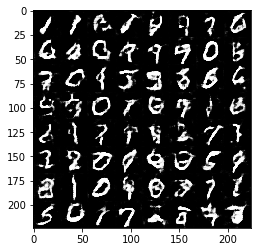

**********************************
Step: 711
Epoch: 1/2
D Loss: 1.5416
G Loss: 0.6000
**********************************
Step: 721
Epoch: 1/2
D Loss: 2.5206
G Loss: 0.1559
**********************************
Step: 731
Epoch: 1/2
D Loss: 1.8566
G Loss: 0.3053
**********************************
Step: 741
Epoch: 1/2
D Loss: 1.5742
G Loss: 0.3946
**********************************
Step: 751
Epoch: 1/2
D Loss: 1.6310
G Loss: 0.3802
**********************************
Step: 761
Epoch: 1/2
D Loss: 1.4141
G Loss: 0.5159
**********************************
Step: 771
Epoch: 1/2
D Loss: 1.4193
G Loss: 0.5011
**********************************
Step: 781
Epoch: 1/2
D Loss: 1.3531
G Loss: 0.5363
**********************************
Step: 791
Epoch: 1/2
D Loss: 1.7068
G Loss: 0.3399
**********************************
Step: 801
Epoch: 1/2
D Loss: 2.0157
G Loss: 0.3126
**********************************


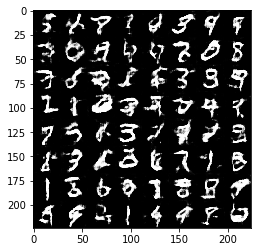

**********************************
Step: 811
Epoch: 1/2
D Loss: 2.1827
G Loss: 0.2052
**********************************
Step: 821
Epoch: 1/2
D Loss: 1.8166
G Loss: 0.3096
**********************************
Step: 831
Epoch: 1/2
D Loss: 1.3319
G Loss: 0.5761
**********************************
Step: 841
Epoch: 1/2
D Loss: 1.4137
G Loss: 0.5291
**********************************
Step: 851
Epoch: 1/2
D Loss: 1.3456
G Loss: 0.5566
**********************************
Step: 861
Epoch: 1/2
D Loss: 1.5033
G Loss: 0.4407
**********************************
Step: 871
Epoch: 1/2
D Loss: 1.6255
G Loss: 0.3752
**********************************
Step: 881
Epoch: 1/2
D Loss: 1.6629
G Loss: 1.2026
**********************************
Step: 891
Epoch: 1/2
D Loss: 1.6195
G Loss: 0.3939
**********************************
Step: 901
Epoch: 1/2
D Loss: 1.4770
G Loss: 0.5245
**********************************


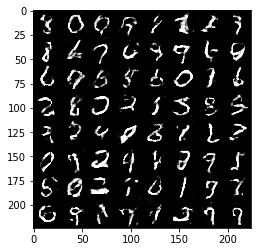

**********************************
Step: 911
Epoch: 1/2
D Loss: 1.6847
G Loss: 0.3503
**********************************
Step: 921
Epoch: 1/2
D Loss: 1.7344
G Loss: 0.3684
**********************************
Step: 931
Epoch: 1/2
D Loss: 1.4546
G Loss: 0.4355
**********************************
Step: 941
Epoch: 2/2
D Loss: 2.2593
G Loss: 0.1886
**********************************
Step: 951
Epoch: 2/2
D Loss: 1.2993
G Loss: 0.7690
**********************************
Step: 961
Epoch: 2/2
D Loss: 1.4515
G Loss: 0.4721
**********************************
Step: 971
Epoch: 2/2
D Loss: 1.2794
G Loss: 0.5736
**********************************
Step: 981
Epoch: 2/2
D Loss: 2.1470
G Loss: 0.2184
**********************************
Step: 991
Epoch: 2/2
D Loss: 1.2518
G Loss: 0.6269
**********************************
Step: 1001
Epoch: 2/2
D Loss: 1.5086
G Loss: 0.4599
**********************************


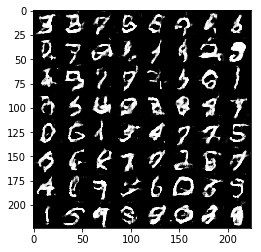

**********************************
Step: 1011
Epoch: 2/2
D Loss: 1.6212
G Loss: 0.4471
**********************************
Step: 1021
Epoch: 2/2
D Loss: 2.6833
G Loss: 0.1249
**********************************
Step: 1031
Epoch: 2/2
D Loss: 1.5955
G Loss: 0.4103
**********************************
Step: 1041
Epoch: 2/2
D Loss: 1.6759
G Loss: 0.3774
**********************************
Step: 1051
Epoch: 2/2
D Loss: 1.6858
G Loss: 0.3448
**********************************
Step: 1061
Epoch: 2/2
D Loss: 1.5134
G Loss: 0.4386
**********************************
Step: 1071
Epoch: 2/2
D Loss: 1.1227
G Loss: 0.7290
**********************************
Step: 1081
Epoch: 2/2
D Loss: 2.2286
G Loss: 0.2064
**********************************
Step: 1091
Epoch: 2/2
D Loss: 1.4474
G Loss: 0.8108
**********************************
Step: 1101
Epoch: 2/2
D Loss: 1.2820
G Loss: 0.6230
**********************************


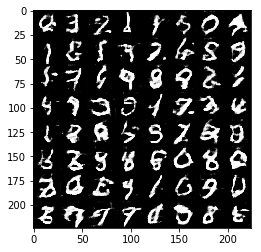

**********************************
Step: 1111
Epoch: 2/2
D Loss: 1.2902
G Loss: 0.5788
**********************************
Step: 1121
Epoch: 2/2
D Loss: 1.9992
G Loss: 0.2670
**********************************
Step: 1131
Epoch: 2/2
D Loss: 1.2419
G Loss: 0.6785
**********************************
Step: 1141
Epoch: 2/2
D Loss: 1.3241
G Loss: 0.5737
**********************************
Step: 1151
Epoch: 2/2
D Loss: 1.5370
G Loss: 0.4270
**********************************
Step: 1161
Epoch: 2/2
D Loss: 2.4485
G Loss: 0.1562
**********************************
Step: 1171
Epoch: 2/2
D Loss: 1.9900
G Loss: 0.2696
**********************************
Step: 1181
Epoch: 2/2
D Loss: 1.9572
G Loss: 0.3022
**********************************
Step: 1191
Epoch: 2/2
D Loss: 1.8390
G Loss: 0.3302
**********************************
Step: 1201
Epoch: 2/2
D Loss: 1.4316
G Loss: 0.4830
**********************************


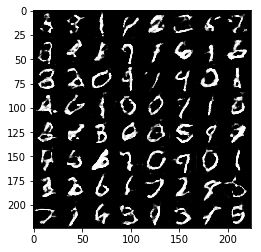

**********************************
Step: 1211
Epoch: 2/2
D Loss: 1.9243
G Loss: 0.3064
**********************************
Step: 1221
Epoch: 2/2
D Loss: 1.3480
G Loss: 0.7428
**********************************
Step: 1231
Epoch: 2/2
D Loss: 1.4860
G Loss: 0.6346
**********************************
Step: 1241
Epoch: 2/2
D Loss: 1.8430
G Loss: 0.3493
**********************************
Step: 1251
Epoch: 2/2
D Loss: 1.8005
G Loss: 0.3286
**********************************
Step: 1261
Epoch: 2/2
D Loss: 1.8373
G Loss: 0.2933
**********************************
Step: 1271
Epoch: 2/2
D Loss: 1.8698
G Loss: 0.3089
**********************************
Step: 1281
Epoch: 2/2
D Loss: 1.2901
G Loss: 0.7867
**********************************
Step: 1291
Epoch: 2/2
D Loss: 2.2565
G Loss: 0.1905
**********************************
Step: 1301
Epoch: 2/2
D Loss: 1.7109
G Loss: 0.3521
**********************************


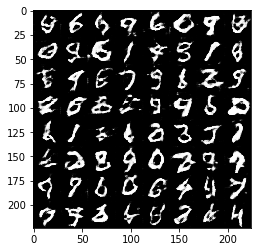

**********************************
Step: 1311
Epoch: 2/2
D Loss: 1.7195
G Loss: 0.3528
**********************************
Step: 1321
Epoch: 2/2
D Loss: 1.6895
G Loss: 0.3632
**********************************
Step: 1331
Epoch: 2/2
D Loss: 1.6504
G Loss: 0.4002
**********************************
Step: 1341
Epoch: 2/2
D Loss: 2.2977
G Loss: 2.6701
**********************************
Step: 1351
Epoch: 2/2
D Loss: 1.9515
G Loss: 0.2709
**********************************
Step: 1361
Epoch: 2/2
D Loss: 1.5370
G Loss: 0.4719
**********************************
Step: 1371
Epoch: 2/2
D Loss: 1.7847
G Loss: 0.3250
**********************************
Step: 1381
Epoch: 2/2
D Loss: 2.2786
G Loss: 0.2062
**********************************
Step: 1391
Epoch: 2/2
D Loss: 0.7968
G Loss: 1.2119
**********************************
Step: 1401
Epoch: 2/2
D Loss: 1.3161
G Loss: 0.5647
**********************************


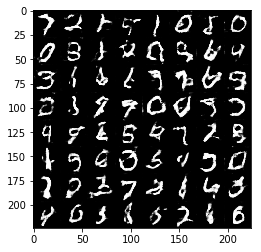

**********************************
Step: 1411
Epoch: 2/2
D Loss: 1.2831
G Loss: 0.6321
**********************************
Step: 1421
Epoch: 2/2
D Loss: 1.8315
G Loss: 0.3217
**********************************
Step: 1431
Epoch: 2/2
D Loss: 3.7618
G Loss: 0.0596
**********************************
Step: 1441
Epoch: 2/2
D Loss: 2.7360
G Loss: 2.8894
**********************************
Step: 1451
Epoch: 2/2
D Loss: 1.1007
G Loss: 0.8913
**********************************
Step: 1461
Epoch: 2/2
D Loss: 0.9985
G Loss: 1.0308
**********************************
Step: 1471
Epoch: 2/2
D Loss: 1.2592
G Loss: 0.5906
**********************************
Step: 1481
Epoch: 2/2
D Loss: 1.8060
G Loss: 0.3360
**********************************
Step: 1491
Epoch: 2/2
D Loss: 1.4749
G Loss: 0.4793
**********************************
Step: 1501
Epoch: 2/2
D Loss: 1.3372
G Loss: 0.5823
**********************************


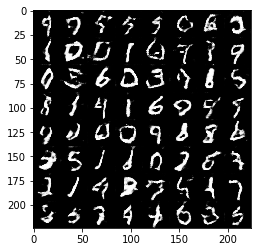

**********************************
Step: 1511
Epoch: 2/2
D Loss: 2.3888
G Loss: 0.1758
**********************************
Step: 1521
Epoch: 2/2
D Loss: 1.4719
G Loss: 0.4753
**********************************
Step: 1531
Epoch: 2/2
D Loss: 1.2262
G Loss: 0.5874
**********************************
Step: 1541
Epoch: 2/2
D Loss: 1.5762
G Loss: 0.4374
**********************************
Step: 1551
Epoch: 2/2
D Loss: 1.4153
G Loss: 0.5136
**********************************
Step: 1561
Epoch: 2/2
D Loss: 1.8826
G Loss: 0.2949
**********************************
Step: 1571
Epoch: 2/2
D Loss: 1.8169
G Loss: 0.5372
**********************************
Step: 1581
Epoch: 2/2
D Loss: 1.3867
G Loss: 0.5375
**********************************
Step: 1591
Epoch: 2/2
D Loss: 1.6749
G Loss: 0.3630
**********************************
Step: 1601
Epoch: 2/2
D Loss: 1.1232
G Loss: 1.1482
**********************************


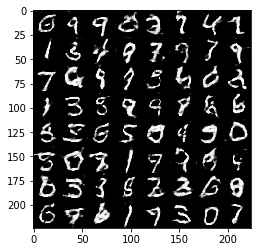

**********************************
Step: 1611
Epoch: 2/2
D Loss: 1.0883
G Loss: 0.8495
**********************************
Step: 1621
Epoch: 2/2
D Loss: 2.1489
G Loss: 0.2270
**********************************
Step: 1631
Epoch: 2/2
D Loss: 1.5582
G Loss: 0.4805
**********************************
Step: 1641
Epoch: 2/2
D Loss: 1.7491
G Loss: 0.3295
**********************************
Step: 1651
Epoch: 2/2
D Loss: 1.7636
G Loss: 0.3459
**********************************
Step: 1661
Epoch: 2/2
D Loss: 2.4489
G Loss: 0.1926
**********************************
Step: 1671
Epoch: 2/2
D Loss: 1.2612
G Loss: 0.6272
**********************************
Step: 1681
Epoch: 2/2
D Loss: 1.3542
G Loss: 0.5372
**********************************
Step: 1691
Epoch: 2/2
D Loss: 1.2251
G Loss: 0.8510
**********************************
Step: 1701
Epoch: 2/2
D Loss: 1.8357
G Loss: 0.3469
**********************************


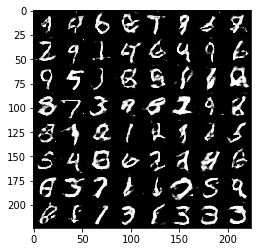

**********************************
Step: 1711
Epoch: 2/2
D Loss: 1.2984
G Loss: 0.7095
**********************************
Step: 1721
Epoch: 2/2
D Loss: 1.3604
G Loss: 0.5256
**********************************
Step: 1731
Epoch: 2/2
D Loss: 1.2779
G Loss: 0.6755
**********************************
Step: 1741
Epoch: 2/2
D Loss: 1.6774
G Loss: 0.3615
**********************************
Step: 1751
Epoch: 2/2
D Loss: 1.2951
G Loss: 0.5997
**********************************
Step: 1761
Epoch: 2/2
D Loss: 1.2015
G Loss: 0.6769
**********************************
Step: 1771
Epoch: 2/2
D Loss: 2.7525
G Loss: 0.1452
**********************************
Step: 1781
Epoch: 2/2
D Loss: 2.0320
G Loss: 0.2829
**********************************
Step: 1791
Epoch: 2/2
D Loss: 1.6044
G Loss: 0.4497
**********************************
Step: 1801
Epoch: 2/2
D Loss: 2.9604
G Loss: 0.1204
**********************************


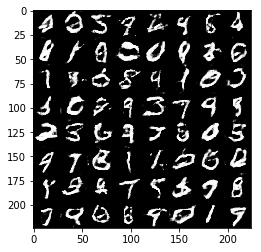

**********************************
Step: 1811
Epoch: 2/2
D Loss: 1.2048
G Loss: 0.9115
**********************************
Step: 1821
Epoch: 2/2
D Loss: 1.3800
G Loss: 0.7273
**********************************
Step: 1831
Epoch: 2/2
D Loss: 2.1549
G Loss: 0.2686
**********************************
Step: 1841
Epoch: 2/2
D Loss: 1.8840
G Loss: 0.3417
**********************************
Step: 1851
Epoch: 2/2
D Loss: 1.5525
G Loss: 0.4950
**********************************
Step: 1861
Epoch: 2/2
D Loss: 1.8673
G Loss: 0.2900
**********************************
Step: 1871
Epoch: 2/2
D Loss: 1.3914
G Loss: 0.5365


In [18]:
batch_size = 64
z_dim = 500
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

**********************************
Step: 1
Epoch: 1/1
D Loss: 9.2127
G Loss: 0.0002
**********************************


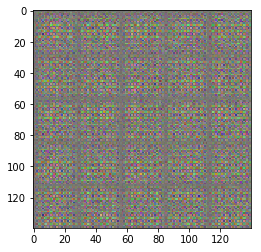

**********************************
Step: 11
Epoch: 1/1
D Loss: 6.0439
G Loss: 0.0051
**********************************
Step: 21
Epoch: 1/1
D Loss: 2.7967
G Loss: 0.2168
**********************************
Step: 31
Epoch: 1/1
D Loss: 4.0167
G Loss: 0.0608
**********************************
Step: 41
Epoch: 1/1
D Loss: 6.0396
G Loss: 0.0095
**********************************
Step: 51
Epoch: 1/1
D Loss: 3.6289
G Loss: 0.0891
**********************************
Step: 61
Epoch: 1/1
D Loss: 5.0903
G Loss: 0.0171
**********************************
Step: 71
Epoch: 1/1
D Loss: 3.8446
G Loss: 0.0453
**********************************
Step: 81
Epoch: 1/1
D Loss: 3.5116
G Loss: 0.0761
**********************************
Step: 91
Epoch: 1/1
D Loss: 3.5409
G Loss: 0.0853
**********************************
Step: 101
Epoch: 1/1
D Loss: 3.1821
G Loss: 0.1208
**********************************


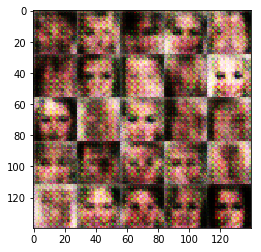

**********************************
Step: 111
Epoch: 1/1
D Loss: 2.9714
G Loss: 0.1284
**********************************
Step: 121
Epoch: 1/1
D Loss: 2.6724
G Loss: 0.1487
**********************************
Step: 131
Epoch: 1/1
D Loss: 2.7839
G Loss: 0.1133
**********************************
Step: 141
Epoch: 1/1
D Loss: 2.8759
G Loss: 0.1456
**********************************
Step: 151
Epoch: 1/1
D Loss: 3.6215
G Loss: 0.0499
**********************************
Step: 161
Epoch: 1/1
D Loss: 3.2594
G Loss: 0.0774
**********************************
Step: 171
Epoch: 1/1
D Loss: 2.5635
G Loss: 0.1561
**********************************
Step: 181
Epoch: 1/1
D Loss: 2.8505
G Loss: 0.0921
**********************************
Step: 191
Epoch: 1/1
D Loss: 2.4449
G Loss: 0.1907
**********************************
Step: 201
Epoch: 1/1
D Loss: 3.1523
G Loss: 0.1484
**********************************


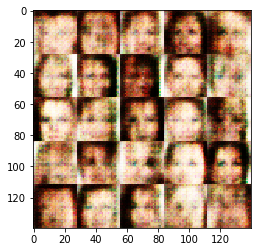

**********************************
Step: 211
Epoch: 1/1
D Loss: 3.5753
G Loss: 0.4279
**********************************
Step: 221
Epoch: 1/1
D Loss: 3.3859
G Loss: 0.0637
**********************************
Step: 231
Epoch: 1/1
D Loss: 2.7965
G Loss: 0.1085
**********************************
Step: 241
Epoch: 1/1
D Loss: 2.9575
G Loss: 0.1329
**********************************
Step: 251
Epoch: 1/1
D Loss: 3.6392
G Loss: 0.0547
**********************************
Step: 261
Epoch: 1/1
D Loss: 2.7648
G Loss: 0.2409
**********************************
Step: 271
Epoch: 1/1
D Loss: 2.5035
G Loss: 0.1502
**********************************
Step: 281
Epoch: 1/1
D Loss: 2.3360
G Loss: 0.4020
**********************************
Step: 291
Epoch: 1/1
D Loss: 3.2409
G Loss: 0.0843
**********************************
Step: 301
Epoch: 1/1
D Loss: 2.7666
G Loss: 0.1363
**********************************


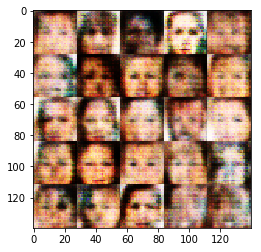

**********************************
Step: 311
Epoch: 1/1
D Loss: 2.4273
G Loss: 0.1722
**********************************
Step: 321
Epoch: 1/1
D Loss: 1.7475
G Loss: 0.3326
**********************************
Step: 331
Epoch: 1/1
D Loss: 4.3581
G Loss: 0.0218
**********************************
Step: 341
Epoch: 1/1
D Loss: 4.7358
G Loss: 0.0172
**********************************
Step: 351
Epoch: 1/1
D Loss: 3.7384
G Loss: 0.0433
**********************************
Step: 361
Epoch: 1/1
D Loss: 3.9153
G Loss: 0.0394
**********************************
Step: 371
Epoch: 1/1
D Loss: 2.8190
G Loss: 0.1631
**********************************
Step: 381
Epoch: 1/1
D Loss: 3.3149
G Loss: 0.0660
**********************************
Step: 391
Epoch: 1/1
D Loss: 3.3234
G Loss: 0.0875
**********************************
Step: 401
Epoch: 1/1
D Loss: 3.4929
G Loss: 0.0634
**********************************


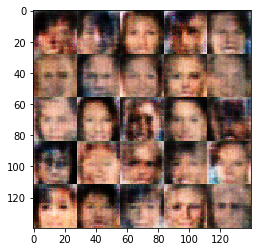

**********************************
Step: 411
Epoch: 1/1
D Loss: 3.1760
G Loss: 0.2980
**********************************
Step: 421
Epoch: 1/1
D Loss: 3.2720
G Loss: 0.0651
**********************************
Step: 431
Epoch: 1/1
D Loss: 1.3441
G Loss: 1.6836
**********************************
Step: 441
Epoch: 1/1
D Loss: 2.1837
G Loss: 0.2468
**********************************
Step: 451
Epoch: 1/1
D Loss: 3.0173
G Loss: 0.0807
**********************************
Step: 461
Epoch: 1/1
D Loss: 3.2403
G Loss: 0.0938
**********************************
Step: 471
Epoch: 1/1
D Loss: 2.5261
G Loss: 0.2842
**********************************
Step: 481
Epoch: 1/1
D Loss: 2.6252
G Loss: 0.1853
**********************************
Step: 491
Epoch: 1/1
D Loss: 2.2960
G Loss: 0.1900
**********************************
Step: 501
Epoch: 1/1
D Loss: 3.3347
G Loss: 1.3495
**********************************


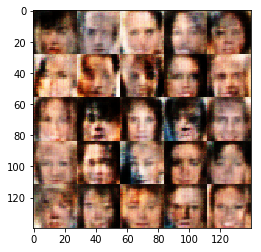

**********************************
Step: 511
Epoch: 1/1
D Loss: 3.0159
G Loss: 0.1005
**********************************
Step: 521
Epoch: 1/1
D Loss: 1.9213
G Loss: 0.3168
**********************************
Step: 531
Epoch: 1/1
D Loss: 3.9475
G Loss: 0.0618
**********************************
Step: 541
Epoch: 1/1
D Loss: 3.6225
G Loss: 0.0575
**********************************
Step: 551
Epoch: 1/1
D Loss: 2.2118
G Loss: 0.2052
**********************************
Step: 561
Epoch: 1/1
D Loss: 1.0781
G Loss: 1.8791
**********************************
Step: 571
Epoch: 1/1
D Loss: 2.9229
G Loss: 0.0870
**********************************
Step: 581
Epoch: 1/1
D Loss: 2.5948
G Loss: 0.1288
**********************************
Step: 591
Epoch: 1/1
D Loss: 3.1792
G Loss: 0.2989
**********************************
Step: 601
Epoch: 1/1
D Loss: 1.7827
G Loss: 0.3687
**********************************


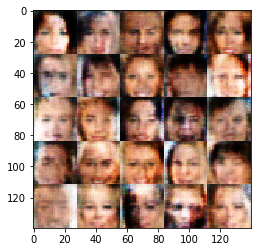

**********************************
Step: 611
Epoch: 1/1
D Loss: 2.7748
G Loss: 0.1121
**********************************
Step: 621
Epoch: 1/1
D Loss: 1.6836
G Loss: 0.4933
**********************************
Step: 631
Epoch: 1/1
D Loss: 1.7803
G Loss: 0.6995
**********************************
Step: 641
Epoch: 1/1
D Loss: 2.5350
G Loss: 0.1782
**********************************
Step: 651
Epoch: 1/1
D Loss: 2.2258
G Loss: 0.2098
**********************************
Step: 661
Epoch: 1/1
D Loss: 1.0083
G Loss: 1.3493
**********************************
Step: 671
Epoch: 1/1
D Loss: 2.2271
G Loss: 0.2213
**********************************
Step: 681
Epoch: 1/1
D Loss: 2.9383
G Loss: 0.0903
**********************************
Step: 691
Epoch: 1/1
D Loss: 2.9656
G Loss: 0.0917
**********************************
Step: 701
Epoch: 1/1
D Loss: 1.8496
G Loss: 1.8461
**********************************


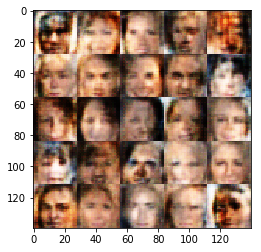

**********************************
Step: 711
Epoch: 1/1
D Loss: 1.3767
G Loss: 0.5439
**********************************
Step: 721
Epoch: 1/1
D Loss: 2.4589
G Loss: 0.2027
**********************************
Step: 731
Epoch: 1/1
D Loss: 2.0532
G Loss: 0.4481
**********************************
Step: 741
Epoch: 1/1
D Loss: 3.0455
G Loss: 0.0804
**********************************
Step: 751
Epoch: 1/1
D Loss: 2.7003
G Loss: 0.1278
**********************************
Step: 761
Epoch: 1/1
D Loss: 2.8836
G Loss: 0.1048
**********************************
Step: 771
Epoch: 1/1
D Loss: 2.2975
G Loss: 0.1950
**********************************
Step: 781
Epoch: 1/1
D Loss: 2.4567
G Loss: 0.1506
**********************************
Step: 791
Epoch: 1/1
D Loss: 2.7840
G Loss: 0.1247
**********************************
Step: 801
Epoch: 1/1
D Loss: 2.9797
G Loss: 0.1111
**********************************


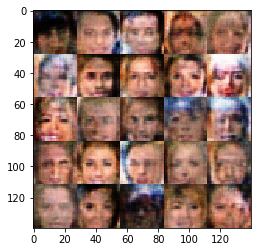

**********************************
Step: 811
Epoch: 1/1
D Loss: 2.2604
G Loss: 0.2077
**********************************
Step: 821
Epoch: 1/1
D Loss: 1.5878
G Loss: 0.5486
**********************************
Step: 831
Epoch: 1/1
D Loss: 2.7295
G Loss: 0.1199
**********************************
Step: 841
Epoch: 1/1
D Loss: 2.9553
G Loss: 0.1141
**********************************
Step: 851
Epoch: 1/1
D Loss: 3.4163
G Loss: 0.0575
**********************************
Step: 861
Epoch: 1/1
D Loss: 2.9252
G Loss: 0.0980
**********************************
Step: 871
Epoch: 1/1
D Loss: 2.8376
G Loss: 0.0976
**********************************
Step: 881
Epoch: 1/1
D Loss: 2.8525
G Loss: 0.1224
**********************************
Step: 891
Epoch: 1/1
D Loss: 3.3133
G Loss: 0.0674
**********************************
Step: 901
Epoch: 1/1
D Loss: 2.7066
G Loss: 0.1245
**********************************


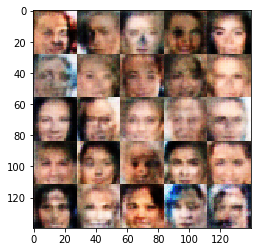

**********************************
Step: 911
Epoch: 1/1
D Loss: 2.8073
G Loss: 0.1001
**********************************
Step: 921
Epoch: 1/1
D Loss: 3.3504
G Loss: 0.0674
**********************************
Step: 931
Epoch: 1/1
D Loss: 1.6764
G Loss: 0.3852
**********************************
Step: 941
Epoch: 1/1
D Loss: 3.3658
G Loss: 0.0553
**********************************
Step: 951
Epoch: 1/1
D Loss: 2.1370
G Loss: 0.2052
**********************************
Step: 961
Epoch: 1/1
D Loss: 1.8434
G Loss: 0.2823
**********************************
Step: 971
Epoch: 1/1
D Loss: 2.7558
G Loss: 0.1151
**********************************
Step: 981
Epoch: 1/1
D Loss: 2.7090
G Loss: 0.1105
**********************************
Step: 991
Epoch: 1/1
D Loss: 2.1568
G Loss: 0.2020
**********************************
Step: 1001
Epoch: 1/1
D Loss: 2.6367
G Loss: 0.1399
**********************************


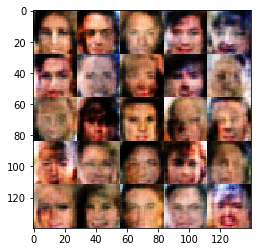

**********************************
Step: 1011
Epoch: 1/1
D Loss: 2.8763
G Loss: 0.1019
**********************************
Step: 1021
Epoch: 1/1
D Loss: 1.4705
G Loss: 0.6904
**********************************
Step: 1031
Epoch: 1/1
D Loss: 2.4453
G Loss: 0.2086
**********************************
Step: 1041
Epoch: 1/1
D Loss: 2.6070
G Loss: 0.1673
**********************************
Step: 1051
Epoch: 1/1
D Loss: 2.2029
G Loss: 0.2613
**********************************
Step: 1061
Epoch: 1/1
D Loss: 2.6429
G Loss: 0.1393
**********************************
Step: 1071
Epoch: 1/1
D Loss: 2.1691
G Loss: 0.3911
**********************************
Step: 1081
Epoch: 1/1
D Loss: 3.3237
G Loss: 0.0652
**********************************
Step: 1091
Epoch: 1/1
D Loss: 3.1639
G Loss: 0.0730
**********************************
Step: 1101
Epoch: 1/1
D Loss: 2.9189
G Loss: 0.0932
**********************************


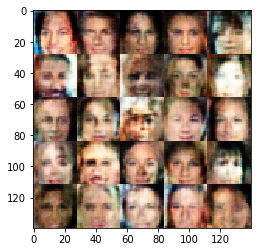

**********************************
Step: 1111
Epoch: 1/1
D Loss: 3.0053
G Loss: 0.0799
**********************************
Step: 1121
Epoch: 1/1
D Loss: 3.0749
G Loss: 0.0866
**********************************
Step: 1131
Epoch: 1/1
D Loss: 3.3772
G Loss: 0.0590
**********************************
Step: 1141
Epoch: 1/1
D Loss: 1.0375
G Loss: 1.3829
**********************************
Step: 1151
Epoch: 1/1
D Loss: 3.0042
G Loss: 0.0792
**********************************
Step: 1161
Epoch: 1/1
D Loss: 2.7928
G Loss: 0.1281
**********************************
Step: 1171
Epoch: 1/1
D Loss: 2.4343
G Loss: 0.1524
**********************************
Step: 1181
Epoch: 1/1
D Loss: 1.6136
G Loss: 0.5259
**********************************
Step: 1191
Epoch: 1/1
D Loss: 2.9985
G Loss: 0.0866
**********************************
Step: 1201
Epoch: 1/1
D Loss: 3.0640
G Loss: 0.0855
**********************************


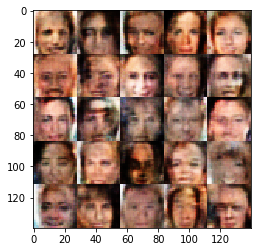

**********************************
Step: 1211
Epoch: 1/1
D Loss: 2.7529
G Loss: 0.1012
**********************************
Step: 1221
Epoch: 1/1
D Loss: 2.8197
G Loss: 0.1130
**********************************
Step: 1231
Epoch: 1/1
D Loss: 2.9447
G Loss: 0.1012
**********************************
Step: 1241
Epoch: 1/1
D Loss: 2.4910
G Loss: 0.1910
**********************************
Step: 1251
Epoch: 1/1
D Loss: 3.0739
G Loss: 0.0961
**********************************
Step: 1261
Epoch: 1/1
D Loss: 2.6367
G Loss: 0.1193
**********************************
Step: 1271
Epoch: 1/1
D Loss: 3.0392
G Loss: 0.1004
**********************************
Step: 1281
Epoch: 1/1
D Loss: 2.8985
G Loss: 0.0995
**********************************
Step: 1291
Epoch: 1/1
D Loss: 3.0185
G Loss: 0.1054
**********************************
Step: 1301
Epoch: 1/1
D Loss: 1.6260
G Loss: 0.4488
**********************************


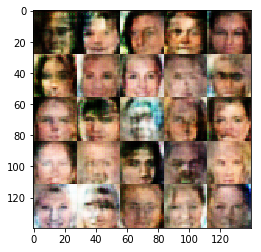

**********************************
Step: 1311
Epoch: 1/1
D Loss: 2.4554
G Loss: 0.1512
**********************************
Step: 1321
Epoch: 1/1
D Loss: 3.7728
G Loss: 0.0354
**********************************
Step: 1331
Epoch: 1/1
D Loss: 2.4358
G Loss: 0.2301
**********************************
Step: 1341
Epoch: 1/1
D Loss: 2.3776
G Loss: 0.5416
**********************************
Step: 1351
Epoch: 1/1
D Loss: 2.7460
G Loss: 0.1128
**********************************
Step: 1361
Epoch: 1/1
D Loss: 3.2300
G Loss: 0.0699
**********************************
Step: 1371
Epoch: 1/1
D Loss: 2.8427
G Loss: 0.0984
**********************************
Step: 1381
Epoch: 1/1
D Loss: 2.7736
G Loss: 0.1173
**********************************
Step: 1391
Epoch: 1/1
D Loss: 2.6484
G Loss: 0.1421
**********************************
Step: 1401
Epoch: 1/1
D Loss: 1.7252
G Loss: 0.4581
**********************************


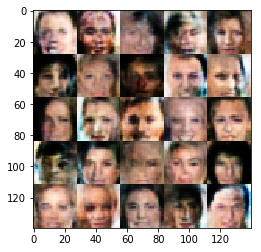

**********************************
Step: 1411
Epoch: 1/1
D Loss: 2.8674
G Loss: 0.1065
**********************************
Step: 1421
Epoch: 1/1
D Loss: 3.0515
G Loss: 0.0783
**********************************
Step: 1431
Epoch: 1/1
D Loss: 3.5253
G Loss: 0.0468
**********************************
Step: 1441
Epoch: 1/1
D Loss: 2.6445
G Loss: 0.1165
**********************************
Step: 1451
Epoch: 1/1
D Loss: 3.5376
G Loss: 0.0525
**********************************
Step: 1461
Epoch: 1/1
D Loss: 3.3492
G Loss: 0.0554
**********************************
Step: 1471
Epoch: 1/1
D Loss: 3.4682
G Loss: 0.0522
**********************************
Step: 1481
Epoch: 1/1
D Loss: 2.9006
G Loss: 0.0991
**********************************
Step: 1491
Epoch: 1/1
D Loss: 3.0411
G Loss: 0.0778
**********************************
Step: 1501
Epoch: 1/1
D Loss: 2.6771
G Loss: 0.1101
**********************************


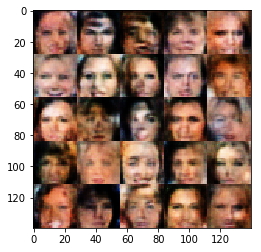

**********************************
Step: 1511
Epoch: 1/1
D Loss: 3.1513
G Loss: 0.0700
**********************************
Step: 1521
Epoch: 1/1
D Loss: 3.1670
G Loss: 0.0737
**********************************
Step: 1531
Epoch: 1/1
D Loss: 2.3675
G Loss: 0.2211
**********************************
Step: 1541
Epoch: 1/1
D Loss: 3.3769
G Loss: 0.0626
**********************************
Step: 1551
Epoch: 1/1
D Loss: 3.7928
G Loss: 0.0358
**********************************
Step: 1561
Epoch: 1/1
D Loss: 2.7961
G Loss: 0.1606
**********************************
Step: 1571
Epoch: 1/1
D Loss: 3.4201
G Loss: 0.0752
**********************************
Step: 1581
Epoch: 1/1
D Loss: 3.1211
G Loss: 0.0788
**********************************
Step: 1591
Epoch: 1/1
D Loss: 2.5320
G Loss: 0.1462
**********************************
Step: 1601
Epoch: 1/1
D Loss: 3.1000
G Loss: 0.1194
**********************************


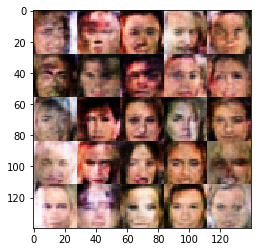

**********************************
Step: 1611
Epoch: 1/1
D Loss: 2.9558
G Loss: 0.1140
**********************************
Step: 1621
Epoch: 1/1
D Loss: 2.9712
G Loss: 0.0883
**********************************
Step: 1631
Epoch: 1/1
D Loss: 2.9965
G Loss: 0.1003
**********************************
Step: 1641
Epoch: 1/1
D Loss: 2.4171
G Loss: 0.2723
**********************************
Step: 1651
Epoch: 1/1
D Loss: 3.7135
G Loss: 0.0398
**********************************
Step: 1661
Epoch: 1/1
D Loss: 3.6298
G Loss: 0.0587
**********************************
Step: 1671
Epoch: 1/1
D Loss: 3.0851
G Loss: 0.0781
**********************************
Step: 1681
Epoch: 1/1
D Loss: 3.0080
G Loss: 0.0967
**********************************
Step: 1691
Epoch: 1/1
D Loss: 2.5457
G Loss: 0.1447
**********************************
Step: 1701
Epoch: 1/1
D Loss: 3.5212
G Loss: 0.0485
**********************************


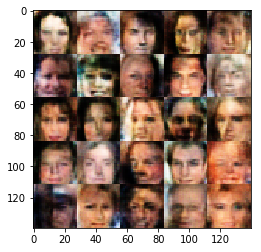

**********************************
Step: 1711
Epoch: 1/1
D Loss: 3.0769
G Loss: 0.0767
**********************************
Step: 1721
Epoch: 1/1
D Loss: 3.0439
G Loss: 0.0964
**********************************
Step: 1731
Epoch: 1/1
D Loss: 3.1400
G Loss: 0.0726
**********************************
Step: 1741
Epoch: 1/1
D Loss: 3.1833
G Loss: 0.0672
**********************************
Step: 1751
Epoch: 1/1
D Loss: 3.7265
G Loss: 0.0402
**********************************
Step: 1761
Epoch: 1/1
D Loss: 2.0399
G Loss: 0.2738
**********************************
Step: 1771
Epoch: 1/1
D Loss: 3.3036
G Loss: 0.0617
**********************************
Step: 1781
Epoch: 1/1
D Loss: 2.9199
G Loss: 0.1243
**********************************
Step: 1791
Epoch: 1/1
D Loss: 4.6951
G Loss: 0.2405
**********************************
Step: 1801
Epoch: 1/1
D Loss: 3.0077
G Loss: 0.0959
**********************************


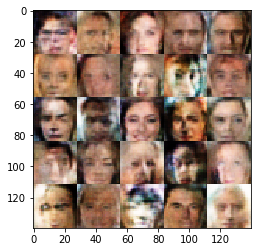

**********************************
Step: 1811
Epoch: 1/1
D Loss: 3.1547
G Loss: 0.5254
**********************************
Step: 1821
Epoch: 1/1
D Loss: 2.8920
G Loss: 0.0989
**********************************
Step: 1831
Epoch: 1/1
D Loss: 2.9782
G Loss: 0.0860
**********************************
Step: 1841
Epoch: 1/1
D Loss: 2.6036
G Loss: 0.1307
**********************************
Step: 1851
Epoch: 1/1
D Loss: 3.3279
G Loss: 0.0636
**********************************
Step: 1861
Epoch: 1/1
D Loss: 3.6096
G Loss: 0.0490
**********************************
Step: 1871
Epoch: 1/1
D Loss: 3.0650
G Loss: 0.0755
**********************************
Step: 1881
Epoch: 1/1
D Loss: 2.7933
G Loss: 0.1416
**********************************
Step: 1891
Epoch: 1/1
D Loss: 3.0673
G Loss: 0.0815
**********************************
Step: 1901
Epoch: 1/1
D Loss: 3.6742
G Loss: 0.0449
**********************************


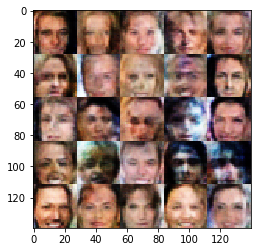

**********************************
Step: 1911
Epoch: 1/1
D Loss: 3.2962
G Loss: 0.0688
**********************************
Step: 1921
Epoch: 1/1
D Loss: 3.0769
G Loss: 0.0743
**********************************
Step: 1931
Epoch: 1/1
D Loss: 3.0023
G Loss: 0.0791
**********************************
Step: 1941
Epoch: 1/1
D Loss: 3.4318
G Loss: 0.0554
**********************************
Step: 1951
Epoch: 1/1
D Loss: 2.9181
G Loss: 0.1114
**********************************
Step: 1961
Epoch: 1/1
D Loss: 3.4804
G Loss: 0.0554
**********************************
Step: 1971
Epoch: 1/1
D Loss: 2.9514
G Loss: 0.1254
**********************************
Step: 1981
Epoch: 1/1
D Loss: 2.8606
G Loss: 0.0994
**********************************
Step: 1991
Epoch: 1/1
D Loss: 3.2637
G Loss: 0.0669
**********************************
Step: 2001
Epoch: 1/1
D Loss: 2.8477
G Loss: 0.1885
**********************************


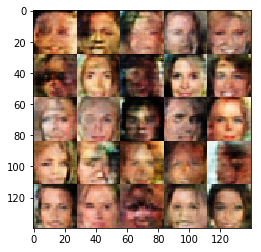

**********************************
Step: 2011
Epoch: 1/1
D Loss: 3.3370
G Loss: 0.0801
**********************************
Step: 2021
Epoch: 1/1
D Loss: 3.3944
G Loss: 0.0524
**********************************
Step: 2031
Epoch: 1/1
D Loss: 3.2304
G Loss: 0.0662
**********************************
Step: 2041
Epoch: 1/1
D Loss: 3.0763
G Loss: 0.0894
**********************************
Step: 2051
Epoch: 1/1
D Loss: 3.7872
G Loss: 0.0382
**********************************
Step: 2061
Epoch: 1/1
D Loss: 3.4946
G Loss: 0.0657
**********************************
Step: 2071
Epoch: 1/1
D Loss: 3.2587
G Loss: 0.0727
**********************************
Step: 2081
Epoch: 1/1
D Loss: 3.1846
G Loss: 0.0698
**********************************
Step: 2091
Epoch: 1/1
D Loss: 3.2805
G Loss: 0.0590
**********************************
Step: 2101
Epoch: 1/1
D Loss: 3.3575
G Loss: 0.0586
**********************************


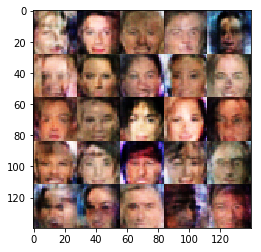

**********************************
Step: 2111
Epoch: 1/1
D Loss: 3.3376
G Loss: 0.0623
**********************************
Step: 2121
Epoch: 1/1
D Loss: 3.8330
G Loss: 0.0385
**********************************
Step: 2131
Epoch: 1/1
D Loss: 3.1361
G Loss: 0.0763
**********************************
Step: 2141
Epoch: 1/1
D Loss: 2.0490
G Loss: 0.2491
**********************************
Step: 2151
Epoch: 1/1
D Loss: 3.0984
G Loss: 0.0767
**********************************
Step: 2161
Epoch: 1/1
D Loss: 3.2243
G Loss: 0.0652
**********************************
Step: 2171
Epoch: 1/1
D Loss: 3.5298
G Loss: 0.0683
**********************************
Step: 2181
Epoch: 1/1
D Loss: 3.1356
G Loss: 0.0985
**********************************
Step: 2191
Epoch: 1/1
D Loss: 3.2772
G Loss: 0.0674
**********************************
Step: 2201
Epoch: 1/1
D Loss: 3.2079
G Loss: 0.0629
**********************************


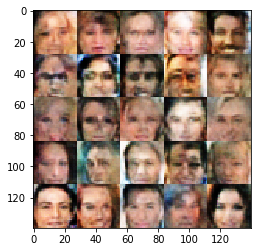

**********************************
Step: 2211
Epoch: 1/1
D Loss: 3.2620
G Loss: 0.0657
**********************************
Step: 2221
Epoch: 1/1
D Loss: 4.0040
G Loss: 0.0309
**********************************
Step: 2231
Epoch: 1/1
D Loss: 2.8795
G Loss: 0.1139
**********************************
Step: 2241
Epoch: 1/1
D Loss: 2.8121
G Loss: 0.1115
**********************************
Step: 2251
Epoch: 1/1
D Loss: 3.0448
G Loss: 0.0824
**********************************
Step: 2261
Epoch: 1/1
D Loss: 3.5138
G Loss: 0.0522
**********************************
Step: 2271
Epoch: 1/1
D Loss: 3.3788
G Loss: 0.0582
**********************************
Step: 2281
Epoch: 1/1
D Loss: 3.1536
G Loss: 0.1471
**********************************
Step: 2291
Epoch: 1/1
D Loss: 3.1618
G Loss: 0.0681
**********************************
Step: 2301
Epoch: 1/1
D Loss: 3.2967
G Loss: 0.0633
**********************************


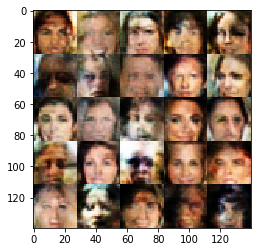

**********************************
Step: 2311
Epoch: 1/1
D Loss: 2.9672
G Loss: 0.0814
**********************************
Step: 2321
Epoch: 1/1
D Loss: 2.0493
G Loss: 0.3169
**********************************
Step: 2331
Epoch: 1/1
D Loss: 3.7312
G Loss: 0.0496
**********************************
Step: 2341
Epoch: 1/1
D Loss: 3.3326
G Loss: 0.0547
**********************************
Step: 2351
Epoch: 1/1
D Loss: 2.7450
G Loss: 0.1117
**********************************
Step: 2361
Epoch: 1/1
D Loss: 3.1825
G Loss: 0.0737
**********************************
Step: 2371
Epoch: 1/1
D Loss: 3.2307
G Loss: 0.0997
**********************************
Step: 2381
Epoch: 1/1
D Loss: 3.6241
G Loss: 0.0465
**********************************
Step: 2391
Epoch: 1/1
D Loss: 3.1188
G Loss: 0.0754
**********************************
Step: 2401
Epoch: 1/1
D Loss: 2.4274
G Loss: 0.1587
**********************************


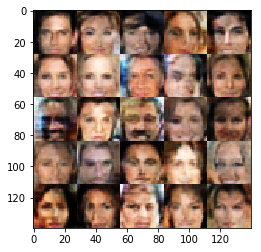

**********************************
Step: 2411
Epoch: 1/1
D Loss: 3.8726
G Loss: 0.0352
**********************************
Step: 2421
Epoch: 1/1
D Loss: 3.2251
G Loss: 0.0798
**********************************
Step: 2431
Epoch: 1/1
D Loss: 2.6677
G Loss: 0.1192
**********************************
Step: 2441
Epoch: 1/1
D Loss: 3.3139
G Loss: 0.0602
**********************************
Step: 2451
Epoch: 1/1
D Loss: 3.1067
G Loss: 0.0757
**********************************
Step: 2461
Epoch: 1/1
D Loss: 3.7395
G Loss: 0.0378
**********************************
Step: 2471
Epoch: 1/1
D Loss: 2.8872
G Loss: 0.1154
**********************************
Step: 2481
Epoch: 1/1
D Loss: 3.7161
G Loss: 0.0410
**********************************
Step: 2491
Epoch: 1/1
D Loss: 3.0622
G Loss: 0.0781
**********************************
Step: 2501
Epoch: 1/1
D Loss: 3.3845
G Loss: 0.0617
**********************************


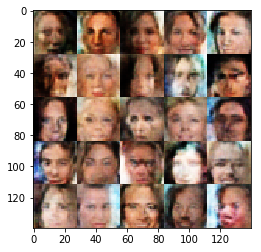

**********************************
Step: 2511
Epoch: 1/1
D Loss: 4.3999
G Loss: 0.0302
**********************************
Step: 2521
Epoch: 1/1
D Loss: 3.1781
G Loss: 0.0748
**********************************
Step: 2531
Epoch: 1/1
D Loss: 3.4356
G Loss: 0.0568
**********************************
Step: 2541
Epoch: 1/1
D Loss: 3.3935
G Loss: 0.0653
**********************************
Step: 2551
Epoch: 1/1
D Loss: 3.0296
G Loss: 0.0848
**********************************
Step: 2561
Epoch: 1/1
D Loss: 3.4467
G Loss: 0.0568
**********************************
Step: 2571
Epoch: 1/1
D Loss: 3.4478
G Loss: 0.1285
**********************************
Step: 2581
Epoch: 1/1
D Loss: 3.2417
G Loss: 0.0642
**********************************
Step: 2591
Epoch: 1/1
D Loss: 3.8590
G Loss: 0.0357
**********************************
Step: 2601
Epoch: 1/1
D Loss: 3.4157
G Loss: 0.0604
**********************************


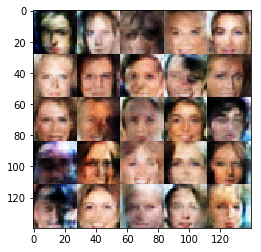

**********************************
Step: 2611
Epoch: 1/1
D Loss: 3.4712
G Loss: 0.0532
**********************************
Step: 2621
Epoch: 1/1
D Loss: 3.8647
G Loss: 0.0356
**********************************
Step: 2631
Epoch: 1/1
D Loss: 3.0753
G Loss: 0.0775
**********************************
Step: 2641
Epoch: 1/1
D Loss: 4.5962
G Loss: 0.0180
**********************************
Step: 2651
Epoch: 1/1
D Loss: 3.7560
G Loss: 0.0379
**********************************
Step: 2661
Epoch: 1/1
D Loss: 3.5249
G Loss: 0.0560
**********************************
Step: 2671
Epoch: 1/1
D Loss: 4.2102
G Loss: 0.0405
**********************************
Step: 2681
Epoch: 1/1
D Loss: 2.3644
G Loss: 0.2062
**********************************
Step: 2691
Epoch: 1/1
D Loss: 3.2115
G Loss: 0.0749
**********************************
Step: 2701
Epoch: 1/1
D Loss: 3.6028
G Loss: 0.0447
**********************************


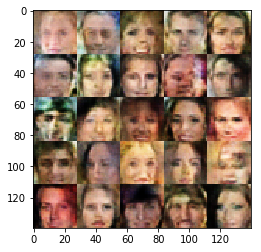

**********************************
Step: 2711
Epoch: 1/1
D Loss: 3.2425
G Loss: 0.0787
**********************************
Step: 2721
Epoch: 1/1
D Loss: 3.7232
G Loss: 0.0433
**********************************
Step: 2731
Epoch: 1/1
D Loss: 3.5415
G Loss: 0.0553
**********************************
Step: 2741
Epoch: 1/1
D Loss: 3.8538
G Loss: 0.0364
**********************************
Step: 2751
Epoch: 1/1
D Loss: 2.9089
G Loss: 0.1001
**********************************
Step: 2761
Epoch: 1/1
D Loss: 2.9779
G Loss: 0.0987
**********************************
Step: 2771
Epoch: 1/1
D Loss: 3.1962
G Loss: 0.0732
**********************************
Step: 2781
Epoch: 1/1
D Loss: 3.5035
G Loss: 0.0509
**********************************
Step: 2791
Epoch: 1/1
D Loss: 2.8633
G Loss: 0.1536
**********************************
Step: 2801
Epoch: 1/1
D Loss: 3.8166
G Loss: 0.0383
**********************************


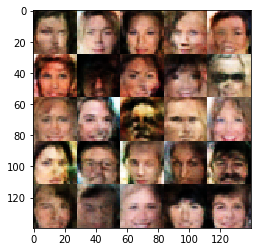

**********************************
Step: 2811
Epoch: 1/1
D Loss: 3.2198
G Loss: 0.0759
**********************************
Step: 2821
Epoch: 1/1
D Loss: 3.1654
G Loss: 0.0758
**********************************
Step: 2831
Epoch: 1/1
D Loss: 3.8902
G Loss: 0.0346
**********************************
Step: 2841
Epoch: 1/1
D Loss: 4.0325
G Loss: 0.0317
**********************************
Step: 2851
Epoch: 1/1
D Loss: 2.7066
G Loss: 0.1209
**********************************
Step: 2861
Epoch: 1/1
D Loss: 2.3151
G Loss: 0.3429
**********************************
Step: 2871
Epoch: 1/1
D Loss: 3.3603
G Loss: 0.0788
**********************************
Step: 2881
Epoch: 1/1
D Loss: 3.3099
G Loss: 0.0645
**********************************
Step: 2891
Epoch: 1/1
D Loss: 3.9435
G Loss: 0.0324
**********************************
Step: 2901
Epoch: 1/1
D Loss: 3.5540
G Loss: 0.0532
**********************************


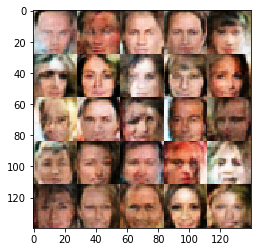

**********************************
Step: 2911
Epoch: 1/1
D Loss: 3.0475
G Loss: 0.0800
**********************************
Step: 2921
Epoch: 1/1
D Loss: 3.5461
G Loss: 0.0578
**********************************
Step: 2931
Epoch: 1/1
D Loss: 3.8447
G Loss: 0.0360
**********************************
Step: 2941
Epoch: 1/1
D Loss: 3.4979
G Loss: 0.0514
**********************************
Step: 2951
Epoch: 1/1
D Loss: 2.6992
G Loss: 0.1703
**********************************
Step: 2961
Epoch: 1/1
D Loss: 3.8718
G Loss: 0.0364
**********************************
Step: 2971
Epoch: 1/1
D Loss: 3.1524
G Loss: 0.0737
**********************************
Step: 2981
Epoch: 1/1
D Loss: 2.8081
G Loss: 0.1067
**********************************
Step: 2991
Epoch: 1/1
D Loss: 4.3816
G Loss: 0.0266
**********************************
Step: 3001
Epoch: 1/1
D Loss: 3.7561
G Loss: 0.0420
**********************************


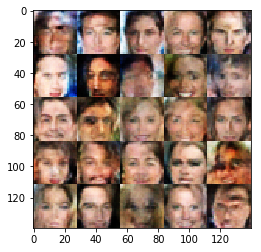

**********************************
Step: 3011
Epoch: 1/1
D Loss: 2.8849
G Loss: 0.0981
**********************************
Step: 3021
Epoch: 1/1
D Loss: 2.9345
G Loss: 0.0966
**********************************
Step: 3031
Epoch: 1/1
D Loss: 3.1078
G Loss: 0.0865
**********************************
Step: 3041
Epoch: 1/1
D Loss: 3.7702
G Loss: 0.0431
**********************************
Step: 3051
Epoch: 1/1
D Loss: 3.8972
G Loss: 0.0342
**********************************
Step: 3061
Epoch: 1/1
D Loss: 3.6465
G Loss: 0.0467
**********************************
Step: 3071
Epoch: 1/1
D Loss: 3.0475
G Loss: 0.1084
**********************************
Step: 3081
Epoch: 1/1
D Loss: 3.2286
G Loss: 0.0853
**********************************
Step: 3091
Epoch: 1/1
D Loss: 3.6413
G Loss: 0.0477
**********************************
Step: 3101
Epoch: 1/1
D Loss: 2.3107
G Loss: 0.2090
**********************************


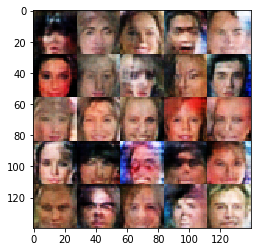

**********************************
Step: 3111
Epoch: 1/1
D Loss: 3.9438
G Loss: 0.0353
**********************************
Step: 3121
Epoch: 1/1
D Loss: 3.6768
G Loss: 0.0792
**********************************
Step: 3131
Epoch: 1/1
D Loss: 3.6947
G Loss: 0.0421
**********************************
Step: 3141
Epoch: 1/1
D Loss: 3.5872
G Loss: 0.0520
**********************************
Step: 3151
Epoch: 1/1
D Loss: 2.8872
G Loss: 0.0962
**********************************
Step: 3161
Epoch: 1/1
D Loss: 3.2013
G Loss: 0.0803
**********************************
Step: 3171
Epoch: 1/1
D Loss: 4.0711
G Loss: 0.0685
**********************************
Step: 3181
Epoch: 1/1
D Loss: 3.4231
G Loss: 0.0585
**********************************
Step: 3191
Epoch: 1/1
D Loss: 3.2041
G Loss: 0.0912
**********************************
Step: 3201
Epoch: 1/1
D Loss: 3.3317
G Loss: 0.0644
**********************************


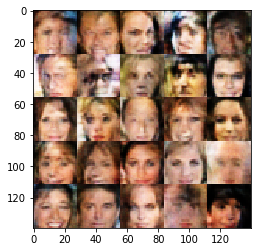

**********************************
Step: 3211
Epoch: 1/1
D Loss: 3.1181
G Loss: 0.0771
**********************************
Step: 3221
Epoch: 1/1
D Loss: 3.4255
G Loss: 0.0708
**********************************
Step: 3231
Epoch: 1/1
D Loss: 3.7038
G Loss: 0.0402
**********************************
Step: 3241
Epoch: 1/1
D Loss: 3.4525
G Loss: 0.0523
**********************************
Step: 3251
Epoch: 1/1
D Loss: 3.2466
G Loss: 0.0676
**********************************
Step: 3261
Epoch: 1/1
D Loss: 3.0649
G Loss: 0.0794
**********************************
Step: 3271
Epoch: 1/1
D Loss: 3.3982
G Loss: 0.0645
**********************************
Step: 3281
Epoch: 1/1
D Loss: 2.9075
G Loss: 0.1293
**********************************
Step: 3291
Epoch: 1/1
D Loss: 2.9386
G Loss: 0.1949
**********************************
Step: 3301
Epoch: 1/1
D Loss: 2.7670
G Loss: 0.1121
**********************************


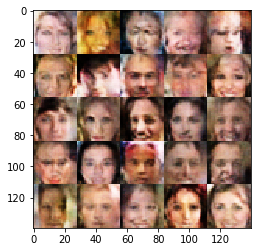

**********************************
Step: 3311
Epoch: 1/1
D Loss: 4.3790
G Loss: 0.0201
**********************************
Step: 3321
Epoch: 1/1
D Loss: 3.5518
G Loss: 0.0502
**********************************
Step: 3331
Epoch: 1/1
D Loss: 3.8835
G Loss: 0.0430
**********************************
Step: 3341
Epoch: 1/1
D Loss: 3.0967
G Loss: 0.0767
**********************************
Step: 3351
Epoch: 1/1
D Loss: 5.0602
G Loss: 0.0123
**********************************
Step: 3361
Epoch: 1/1
D Loss: 3.9878
G Loss: 0.0306
**********************************
Step: 3371
Epoch: 1/1
D Loss: 3.9113
G Loss: 0.0338
**********************************
Step: 3381
Epoch: 1/1
D Loss: 3.0854
G Loss: 0.0787
**********************************
Step: 3391
Epoch: 1/1
D Loss: 3.2501
G Loss: 0.0730
**********************************
Step: 3401
Epoch: 1/1
D Loss: 3.3317
G Loss: 0.0668
**********************************


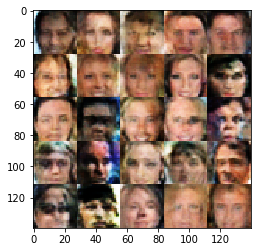

**********************************
Step: 3411
Epoch: 1/1
D Loss: 3.2492
G Loss: 0.0655
**********************************
Step: 3421
Epoch: 1/1
D Loss: 3.3239
G Loss: 0.0590
**********************************
Step: 3431
Epoch: 1/1
D Loss: 2.9768
G Loss: 0.1051
**********************************
Step: 3441
Epoch: 1/1
D Loss: 3.1392
G Loss: 0.0903
**********************************
Step: 3451
Epoch: 1/1
D Loss: 3.7197
G Loss: 0.0458
**********************************
Step: 3461
Epoch: 1/1
D Loss: 3.5174
G Loss: 0.0530
**********************************
Step: 3471
Epoch: 1/1
D Loss: 3.0289
G Loss: 0.0843
**********************************
Step: 3481
Epoch: 1/1
D Loss: 2.3609
G Loss: 0.1650
**********************************
Step: 3491
Epoch: 1/1
D Loss: 3.9139
G Loss: 0.0390
**********************************
Step: 3501
Epoch: 1/1
D Loss: 2.7879
G Loss: 0.1105
**********************************


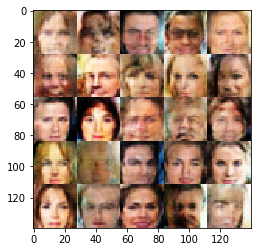

**********************************
Step: 3511
Epoch: 1/1
D Loss: 3.4743
G Loss: 0.0612
**********************************
Step: 3521
Epoch: 1/1
D Loss: 2.8990
G Loss: 0.0955
**********************************
Step: 3531
Epoch: 1/1
D Loss: 2.4501
G Loss: 0.1885
**********************************
Step: 3541
Epoch: 1/1
D Loss: 3.8306
G Loss: 0.0363
**********************************
Step: 3551
Epoch: 1/1
D Loss: 3.3360
G Loss: 0.0662
**********************************
Step: 3561
Epoch: 1/1
D Loss: 3.5153
G Loss: 0.0504
**********************************
Step: 3571
Epoch: 1/1
D Loss: 3.8785
G Loss: 0.0353
**********************************
Step: 3581
Epoch: 1/1
D Loss: 2.6139
G Loss: 0.1299
**********************************
Step: 3591
Epoch: 1/1
D Loss: 2.3121
G Loss: 0.1825
**********************************
Step: 3601
Epoch: 1/1
D Loss: 3.3236
G Loss: 0.0600
**********************************


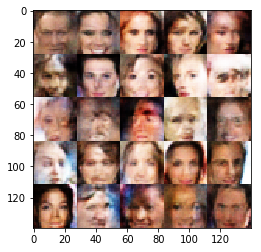

**********************************
Step: 3611
Epoch: 1/1
D Loss: 2.6468
G Loss: 0.1569
**********************************
Step: 3621
Epoch: 1/1
D Loss: 3.4798
G Loss: 0.0547
**********************************
Step: 3631
Epoch: 1/1
D Loss: 3.0592
G Loss: 0.0816
**********************************
Step: 3641
Epoch: 1/1
D Loss: 3.5167
G Loss: 0.0554
**********************************
Step: 3651
Epoch: 1/1
D Loss: 3.6493
G Loss: 0.0423
**********************************
Step: 3661
Epoch: 1/1
D Loss: 4.0719
G Loss: 0.0298
**********************************
Step: 3671
Epoch: 1/1
D Loss: 3.2015
G Loss: 0.0666
**********************************
Step: 3681
Epoch: 1/1
D Loss: 3.7375
G Loss: 0.0416
**********************************
Step: 3691
Epoch: 1/1
D Loss: 3.4078
G Loss: 0.0552
**********************************
Step: 3701
Epoch: 1/1
D Loss: 2.9782
G Loss: 0.1805
**********************************


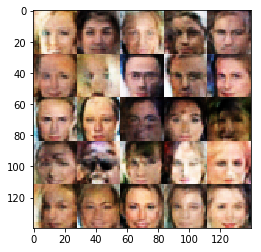

**********************************
Step: 3711
Epoch: 1/1
D Loss: 3.7541
G Loss: 0.0423
**********************************
Step: 3721
Epoch: 1/1
D Loss: 3.4889
G Loss: 0.0552
**********************************
Step: 3731
Epoch: 1/1
D Loss: 3.0017
G Loss: 0.0912
**********************************
Step: 3741
Epoch: 1/1
D Loss: 4.6125
G Loss: 0.0243
**********************************
Step: 3751
Epoch: 1/1
D Loss: 3.3246
G Loss: 0.0640
**********************************
Step: 3761
Epoch: 1/1
D Loss: 2.9313
G Loss: 0.0976
**********************************
Step: 3771
Epoch: 1/1
D Loss: 3.9931
G Loss: 0.0301
**********************************
Step: 3781
Epoch: 1/1
D Loss: 3.3275
G Loss: 0.0668
**********************************
Step: 3791
Epoch: 1/1
D Loss: 3.2708
G Loss: 0.0685
**********************************
Step: 3801
Epoch: 1/1
D Loss: 3.4440
G Loss: 0.0584
**********************************


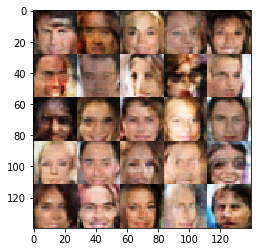

**********************************
Step: 3811
Epoch: 1/1
D Loss: 3.7272
G Loss: 0.0422
**********************************
Step: 3821
Epoch: 1/1
D Loss: 3.7287
G Loss: 0.1286
**********************************
Step: 3831
Epoch: 1/1
D Loss: 3.5792
G Loss: 0.0796
**********************************
Step: 3841
Epoch: 1/1
D Loss: 3.8582
G Loss: 0.0385
**********************************
Step: 3851
Epoch: 1/1
D Loss: 3.3513
G Loss: 0.0631
**********************************
Step: 3861
Epoch: 1/1
D Loss: 4.2184
G Loss: 0.0366
**********************************
Step: 3871
Epoch: 1/1
D Loss: 3.6954
G Loss: 0.0408
**********************************
Step: 3881
Epoch: 1/1
D Loss: 3.1508
G Loss: 0.0765
**********************************
Step: 3891
Epoch: 1/1
D Loss: 3.3457
G Loss: 0.1256
**********************************
Step: 3901
Epoch: 1/1
D Loss: 3.7430
G Loss: 0.0386
**********************************


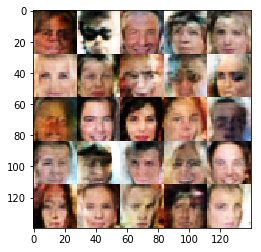

**********************************
Step: 3911
Epoch: 1/1
D Loss: 3.0893
G Loss: 0.0721
**********************************
Step: 3921
Epoch: 1/1
D Loss: 3.7797
G Loss: 0.0425
**********************************
Step: 3931
Epoch: 1/1
D Loss: 3.4901
G Loss: 0.0512
**********************************
Step: 3941
Epoch: 1/1
D Loss: 3.2798
G Loss: 0.0631
**********************************
Step: 3951
Epoch: 1/1
D Loss: 3.4162
G Loss: 0.0710
**********************************
Step: 3961
Epoch: 1/1
D Loss: 3.0760
G Loss: 0.0828
**********************************
Step: 3971
Epoch: 1/1
D Loss: 3.2244
G Loss: 0.0656
**********************************
Step: 3981
Epoch: 1/1
D Loss: 3.5498
G Loss: 0.0502
**********************************
Step: 3991
Epoch: 1/1
D Loss: 3.5595
G Loss: 0.0483
**********************************
Step: 4001
Epoch: 1/1
D Loss: 3.4798
G Loss: 0.0619
**********************************


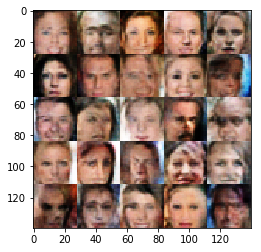

**********************************
Step: 4011
Epoch: 1/1
D Loss: 3.4019
G Loss: 0.0549
**********************************
Step: 4021
Epoch: 1/1
D Loss: 3.6398
G Loss: 0.0482
**********************************
Step: 4031
Epoch: 1/1
D Loss: 3.9832
G Loss: 0.0312
**********************************
Step: 4041
Epoch: 1/1
D Loss: 3.1340
G Loss: 0.0935
**********************************
Step: 4051
Epoch: 1/1
D Loss: 3.3700
G Loss: 0.0643
**********************************
Step: 4061
Epoch: 1/1
D Loss: 3.2316
G Loss: 0.0680
**********************************
Step: 4071
Epoch: 1/1
D Loss: 3.7512
G Loss: 0.0458
**********************************
Step: 4081
Epoch: 1/1
D Loss: 3.8419
G Loss: 0.0383
**********************************
Step: 4091
Epoch: 1/1
D Loss: 3.4924
G Loss: 0.0532
**********************************
Step: 4101
Epoch: 1/1
D Loss: 3.6614
G Loss: 0.0422
**********************************


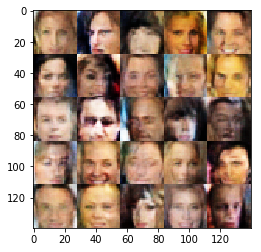

**********************************
Step: 4111
Epoch: 1/1
D Loss: 2.7768
G Loss: 0.3736
**********************************
Step: 4121
Epoch: 1/1
D Loss: 3.6190
G Loss: 0.0720
**********************************
Step: 4131
Epoch: 1/1
D Loss: 3.5338
G Loss: 0.0580
**********************************
Step: 4141
Epoch: 1/1
D Loss: 3.0396
G Loss: 0.0759
**********************************
Step: 4151
Epoch: 1/1
D Loss: 3.4022
G Loss: 0.0660
**********************************
Step: 4161
Epoch: 1/1
D Loss: 3.2316
G Loss: 0.0847
**********************************
Step: 4171
Epoch: 1/1
D Loss: 4.0254
G Loss: 0.0363
**********************************
Step: 4181
Epoch: 1/1
D Loss: 2.0459
G Loss: 0.2525
**********************************
Step: 4191
Epoch: 1/1
D Loss: 3.3676
G Loss: 0.0583
**********************************
Step: 4201
Epoch: 1/1
D Loss: 3.7485
G Loss: 0.0659
**********************************


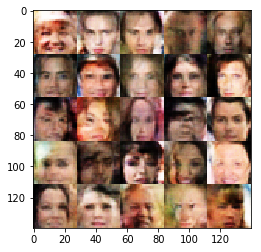

**********************************
Step: 4211
Epoch: 1/1
D Loss: 4.5310
G Loss: 0.0194
**********************************
Step: 4221
Epoch: 1/1
D Loss: 3.9483
G Loss: 0.0394
**********************************
Step: 4231
Epoch: 1/1
D Loss: 3.5131
G Loss: 0.0513
**********************************
Step: 4241
Epoch: 1/1
D Loss: 3.2064
G Loss: 0.1042
**********************************
Step: 4251
Epoch: 1/1
D Loss: 3.4205
G Loss: 0.0533
**********************************
Step: 4261
Epoch: 1/1
D Loss: 2.9335
G Loss: 0.0947
**********************************
Step: 4271
Epoch: 1/1
D Loss: 3.5748
G Loss: 0.1086
**********************************
Step: 4281
Epoch: 1/1
D Loss: 3.1246
G Loss: 0.0869
**********************************
Step: 4291
Epoch: 1/1
D Loss: 3.3178
G Loss: 0.0656
**********************************
Step: 4301
Epoch: 1/1
D Loss: 5.0989
G Loss: 0.0119
**********************************


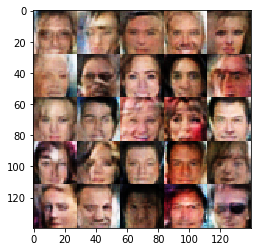

**********************************
Step: 4311
Epoch: 1/1
D Loss: 3.4841
G Loss: 0.0792
**********************************
Step: 4321
Epoch: 1/1
D Loss: 3.4357
G Loss: 0.0558
**********************************
Step: 4331
Epoch: 1/1
D Loss: 3.4711
G Loss: 0.0545
**********************************
Step: 4341
Epoch: 1/1
D Loss: 2.8610
G Loss: 0.1239
**********************************
Step: 4351
Epoch: 1/1
D Loss: 3.2914
G Loss: 0.0671
**********************************
Step: 4361
Epoch: 1/1
D Loss: 3.0309
G Loss: 0.0831
**********************************
Step: 4371
Epoch: 1/1
D Loss: 3.1676
G Loss: 0.1182
**********************************
Step: 4381
Epoch: 1/1
D Loss: 3.0867
G Loss: 0.0793
**********************************
Step: 4391
Epoch: 1/1
D Loss: 3.0272
G Loss: 0.1048
**********************************
Step: 4401
Epoch: 1/1
D Loss: 3.3145
G Loss: 0.0617
**********************************


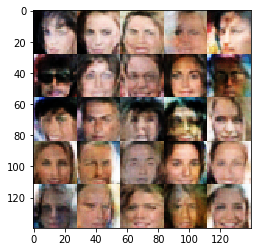

**********************************
Step: 4411
Epoch: 1/1
D Loss: 3.5673
G Loss: 0.0472
**********************************
Step: 4421
Epoch: 1/1
D Loss: 3.0565
G Loss: 0.1028
**********************************
Step: 4431
Epoch: 1/1
D Loss: 3.3163
G Loss: 0.0696
**********************************
Step: 4441
Epoch: 1/1
D Loss: 3.3241
G Loss: 0.0597
**********************************
Step: 4451
Epoch: 1/1
D Loss: 4.1604
G Loss: 0.0285
**********************************
Step: 4461
Epoch: 1/1
D Loss: 3.3908
G Loss: 0.0599
**********************************
Step: 4471
Epoch: 1/1
D Loss: 3.9722
G Loss: 0.0339
**********************************
Step: 4481
Epoch: 1/1
D Loss: 3.6250
G Loss: 0.0472
**********************************
Step: 4491
Epoch: 1/1
D Loss: 4.1222
G Loss: 0.0407
**********************************
Step: 4501
Epoch: 1/1
D Loss: 3.8143
G Loss: 0.0371
**********************************


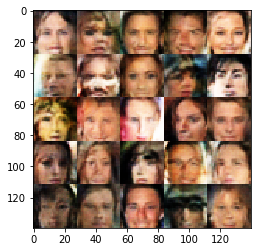

**********************************
Step: 4511
Epoch: 1/1
D Loss: 3.9069
G Loss: 0.0376
**********************************
Step: 4521
Epoch: 1/1
D Loss: 3.5124
G Loss: 0.0559
**********************************
Step: 4531
Epoch: 1/1
D Loss: 3.1732
G Loss: 0.0786
**********************************
Step: 4541
Epoch: 1/1
D Loss: 3.6457
G Loss: 0.0453
**********************************
Step: 4551
Epoch: 1/1
D Loss: 3.8842
G Loss: 0.0381
**********************************
Step: 4561
Epoch: 1/1
D Loss: 4.6324
G Loss: 0.0170
**********************************
Step: 4571
Epoch: 1/1
D Loss: 4.2356
G Loss: 0.0269
**********************************
Step: 4581
Epoch: 1/1
D Loss: 2.7799
G Loss: 0.1598
**********************************
Step: 4591
Epoch: 1/1
D Loss: 3.7244
G Loss: 0.0386
**********************************
Step: 4601
Epoch: 1/1
D Loss: 4.0227
G Loss: 0.0299
**********************************


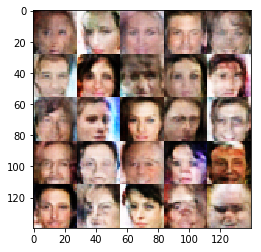

**********************************
Step: 4611
Epoch: 1/1
D Loss: 3.4905
G Loss: 0.0478
**********************************
Step: 4621
Epoch: 1/1
D Loss: 4.0999
G Loss: 0.0331
**********************************
Step: 4631
Epoch: 1/1
D Loss: 3.3812
G Loss: 0.0620
**********************************
Step: 4641
Epoch: 1/1
D Loss: 3.0757
G Loss: 0.0837
**********************************
Step: 4651
Epoch: 1/1
D Loss: 4.0848
G Loss: 0.0302
**********************************
Step: 4661
Epoch: 1/1
D Loss: 3.6146
G Loss: 0.0582
**********************************
Step: 4671
Epoch: 1/1
D Loss: 3.2700
G Loss: 0.0717
**********************************
Step: 4681
Epoch: 1/1
D Loss: 3.1677
G Loss: 0.0689
**********************************
Step: 4691
Epoch: 1/1
D Loss: 2.7457
G Loss: 0.1203
**********************************
Step: 4701
Epoch: 1/1
D Loss: 4.0563
G Loss: 0.0343
**********************************


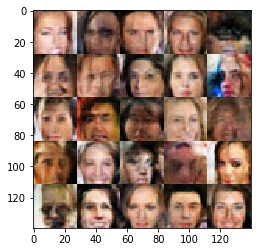

**********************************
Step: 4711
Epoch: 1/1
D Loss: 3.5970
G Loss: 0.0526
**********************************
Step: 4721
Epoch: 1/1
D Loss: 3.5241
G Loss: 0.0564
**********************************
Step: 4731
Epoch: 1/1
D Loss: 3.8555
G Loss: 0.0380
**********************************
Step: 4741
Epoch: 1/1
D Loss: 3.3449
G Loss: 0.0642
**********************************
Step: 4751
Epoch: 1/1
D Loss: 3.8042
G Loss: 0.0353
**********************************
Step: 4761
Epoch: 1/1
D Loss: 3.6796
G Loss: 0.0401
**********************************
Step: 4771
Epoch: 1/1
D Loss: 3.2666
G Loss: 0.0900
**********************************
Step: 4781
Epoch: 1/1
D Loss: 3.2111
G Loss: 0.0729
**********************************
Step: 4791
Epoch: 1/1
D Loss: 3.2931
G Loss: 0.0745
**********************************
Step: 4801
Epoch: 1/1
D Loss: 3.2246
G Loss: 0.0626
**********************************


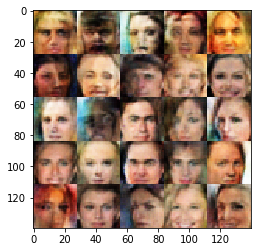

**********************************
Step: 4811
Epoch: 1/1
D Loss: 3.2527
G Loss: 0.0713
**********************************
Step: 4821
Epoch: 1/1
D Loss: 3.6877
G Loss: 0.0502
**********************************
Step: 4831
Epoch: 1/1
D Loss: 3.9804
G Loss: 0.0333
**********************************
Step: 4841
Epoch: 1/1
D Loss: 3.6633
G Loss: 0.0463
**********************************
Step: 4851
Epoch: 1/1
D Loss: 4.0013
G Loss: 0.0321
**********************************
Step: 4861
Epoch: 1/1
D Loss: 3.4041
G Loss: 0.0629
**********************************
Step: 4871
Epoch: 1/1
D Loss: 3.7259
G Loss: 0.0406
**********************************
Step: 4881
Epoch: 1/1
D Loss: 3.4909
G Loss: 0.0843
**********************************
Step: 4891
Epoch: 1/1
D Loss: 3.6550
G Loss: 0.0453
**********************************
Step: 4901
Epoch: 1/1
D Loss: 3.0247
G Loss: 0.0865
**********************************


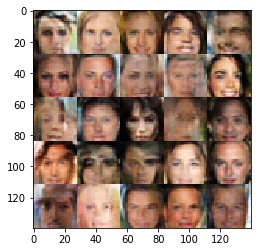

**********************************
Step: 4911
Epoch: 1/1
D Loss: 2.1246
G Loss: 0.2091
**********************************
Step: 4921
Epoch: 1/1
D Loss: 2.5396
G Loss: 0.3698
**********************************
Step: 4931
Epoch: 1/1
D Loss: 3.0503
G Loss: 0.0883
**********************************
Step: 4941
Epoch: 1/1
D Loss: 3.4831
G Loss: 0.0603
**********************************
Step: 4951
Epoch: 1/1
D Loss: 3.3794
G Loss: 0.0593
**********************************
Step: 4961
Epoch: 1/1
D Loss: 3.2338
G Loss: 0.0741
**********************************
Step: 4971
Epoch: 1/1
D Loss: 4.1941
G Loss: 0.0281
**********************************
Step: 4981
Epoch: 1/1
D Loss: 3.1805
G Loss: 0.0778
**********************************
Step: 4991
Epoch: 1/1
D Loss: 3.2951
G Loss: 0.0737
**********************************
Step: 5001
Epoch: 1/1
D Loss: 3.2936
G Loss: 0.0590
**********************************


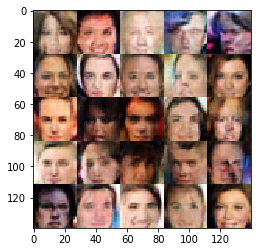

**********************************
Step: 5011
Epoch: 1/1
D Loss: 2.6249
G Loss: 1.1170
**********************************
Step: 5021
Epoch: 1/1
D Loss: 3.6908
G Loss: 0.0471
**********************************
Step: 5031
Epoch: 1/1
D Loss: 3.7374
G Loss: 0.0411
**********************************
Step: 5041
Epoch: 1/1
D Loss: 3.7086
G Loss: 0.0457
**********************************
Step: 5051
Epoch: 1/1
D Loss: 2.7569
G Loss: 0.1022
**********************************
Step: 5061
Epoch: 1/1
D Loss: 3.0806
G Loss: 0.0793
**********************************
Step: 5071
Epoch: 1/1
D Loss: 1.7499
G Loss: 0.3573
**********************************
Step: 5081
Epoch: 1/1
D Loss: 4.8240
G Loss: 0.0135
**********************************
Step: 5091
Epoch: 1/1
D Loss: 3.2820
G Loss: 0.0702
**********************************
Step: 5101
Epoch: 1/1
D Loss: 2.9861
G Loss: 0.0825
**********************************


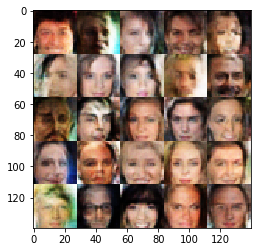

**********************************
Step: 5111
Epoch: 1/1
D Loss: 1.9264
G Loss: 0.2835
**********************************
Step: 5121
Epoch: 1/1
D Loss: 3.3322
G Loss: 0.0794
**********************************
Step: 5131
Epoch: 1/1
D Loss: 2.9444
G Loss: 0.1017
**********************************
Step: 5141
Epoch: 1/1
D Loss: 3.2056
G Loss: 0.0676
**********************************
Step: 5151
Epoch: 1/1
D Loss: 3.5553
G Loss: 0.0463
**********************************
Step: 5161
Epoch: 1/1
D Loss: 3.7754
G Loss: 0.0424
**********************************
Step: 5171
Epoch: 1/1
D Loss: 3.2181
G Loss: 0.0703
**********************************
Step: 5181
Epoch: 1/1
D Loss: 3.6897
G Loss: 0.0397
**********************************
Step: 5191
Epoch: 1/1
D Loss: 3.3200
G Loss: 0.0670
**********************************
Step: 5201
Epoch: 1/1
D Loss: 3.3050
G Loss: 0.0644
**********************************


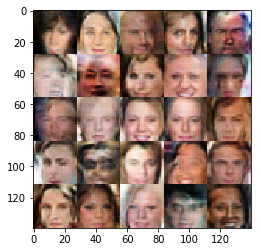

**********************************
Step: 5211
Epoch: 1/1
D Loss: 3.4151
G Loss: 0.0596
**********************************
Step: 5221
Epoch: 1/1
D Loss: 2.6305
G Loss: 0.1445
**********************************
Step: 5231
Epoch: 1/1
D Loss: 3.0330
G Loss: 0.1055
**********************************
Step: 5241
Epoch: 1/1
D Loss: 2.2956
G Loss: 0.2102
**********************************
Step: 5251
Epoch: 1/1
D Loss: 3.5745
G Loss: 0.0549
**********************************
Step: 5261
Epoch: 1/1
D Loss: 2.2663
G Loss: 0.1846
**********************************
Step: 5271
Epoch: 1/1
D Loss: 3.1866
G Loss: 0.0898
**********************************
Step: 5281
Epoch: 1/1
D Loss: 3.9847
G Loss: 0.0318
**********************************
Step: 5291
Epoch: 1/1
D Loss: 3.3612
G Loss: 0.0639
**********************************
Step: 5301
Epoch: 1/1
D Loss: 3.7313
G Loss: 0.0425
**********************************


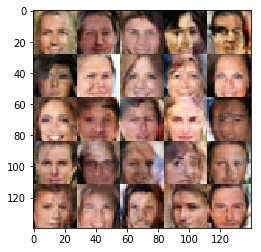

**********************************
Step: 5311
Epoch: 1/1
D Loss: 3.1804
G Loss: 0.0753
**********************************
Step: 5321
Epoch: 1/1
D Loss: 4.5570
G Loss: 0.0175
**********************************
Step: 5331
Epoch: 1/1
D Loss: 3.3397
G Loss: 0.0708
**********************************
Step: 5341
Epoch: 1/1
D Loss: 4.3027
G Loss: 0.0243
**********************************
Step: 5351
Epoch: 1/1
D Loss: 2.9943
G Loss: 0.1712
**********************************
Step: 5361
Epoch: 1/1
D Loss: 3.6734
G Loss: 0.0429
**********************************
Step: 5371
Epoch: 1/1
D Loss: 3.4018
G Loss: 0.0668
**********************************
Step: 5381
Epoch: 1/1
D Loss: 3.8385
G Loss: 0.0414
**********************************
Step: 5391
Epoch: 1/1
D Loss: 3.1634
G Loss: 0.0802
**********************************
Step: 5401
Epoch: 1/1
D Loss: 3.3015
G Loss: 0.0638
**********************************


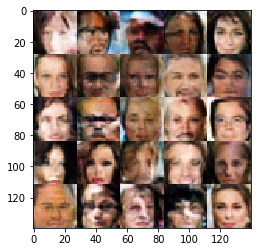

**********************************
Step: 5411
Epoch: 1/1
D Loss: 3.7788
G Loss: 0.0503
**********************************
Step: 5421
Epoch: 1/1
D Loss: 3.7991
G Loss: 0.0461
**********************************
Step: 5431
Epoch: 1/1
D Loss: 3.3994
G Loss: 0.0590
**********************************
Step: 5441
Epoch: 1/1
D Loss: 3.0501
G Loss: 0.0793
**********************************
Step: 5451
Epoch: 1/1
D Loss: 3.8767
G Loss: 0.0408
**********************************
Step: 5461
Epoch: 1/1
D Loss: 3.8530
G Loss: 0.0526
**********************************
Step: 5471
Epoch: 1/1
D Loss: 3.8970
G Loss: 0.0341
**********************************
Step: 5481
Epoch: 1/1
D Loss: 3.6206
G Loss: 0.0466
**********************************
Step: 5491
Epoch: 1/1
D Loss: 3.4147
G Loss: 0.0538
**********************************
Step: 5501
Epoch: 1/1
D Loss: 3.3727
G Loss: 0.0949
**********************************


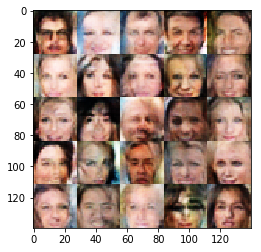

**********************************
Step: 5511
Epoch: 1/1
D Loss: 2.6630
G Loss: 0.1372
**********************************
Step: 5521
Epoch: 1/1
D Loss: 2.5398
G Loss: 0.1752
**********************************
Step: 5531
Epoch: 1/1
D Loss: 3.9343
G Loss: 0.0375
**********************************
Step: 5541
Epoch: 1/1
D Loss: 3.4242
G Loss: 0.0596
**********************************
Step: 5551
Epoch: 1/1
D Loss: 3.0049
G Loss: 0.0874
**********************************
Step: 5561
Epoch: 1/1
D Loss: 3.2958
G Loss: 0.0687
**********************************
Step: 5571
Epoch: 1/1
D Loss: 3.9646
G Loss: 0.0305
**********************************
Step: 5581
Epoch: 1/1
D Loss: 3.4895
G Loss: 0.0676
**********************************
Step: 5591
Epoch: 1/1
D Loss: 3.1586
G Loss: 0.0732
**********************************
Step: 5601
Epoch: 1/1
D Loss: 2.1712
G Loss: 0.2441
**********************************


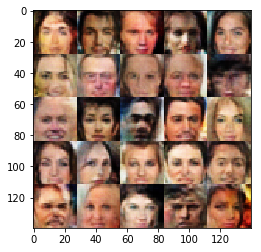

**********************************
Step: 5611
Epoch: 1/1
D Loss: 3.1616
G Loss: 0.0747
**********************************
Step: 5621
Epoch: 1/1
D Loss: 3.7239
G Loss: 0.0734
**********************************
Step: 5631
Epoch: 1/1
D Loss: 1.6758
G Loss: 0.4842
**********************************
Step: 5641
Epoch: 1/1
D Loss: 3.4048
G Loss: 0.0622
**********************************
Step: 5651
Epoch: 1/1
D Loss: 4.4656
G Loss: 0.0210
**********************************
Step: 5661
Epoch: 1/1
D Loss: 4.0152
G Loss: 0.0334
**********************************
Step: 5671
Epoch: 1/1
D Loss: 2.8811
G Loss: 0.1222
**********************************
Step: 5681
Epoch: 1/1
D Loss: 3.4572
G Loss: 0.0557
**********************************
Step: 5691
Epoch: 1/1
D Loss: 3.3281
G Loss: 0.0619
**********************************
Step: 5701
Epoch: 1/1
D Loss: 3.6567
G Loss: 0.0433
**********************************


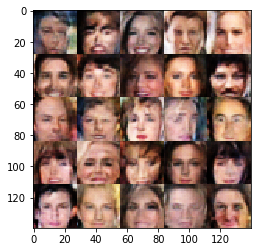

**********************************
Step: 5711
Epoch: 1/1
D Loss: 3.4306
G Loss: 0.0528
**********************************
Step: 5721
Epoch: 1/1
D Loss: 3.4725
G Loss: 0.0629
**********************************
Step: 5731
Epoch: 1/1
D Loss: 3.9007
G Loss: 0.0405
**********************************
Step: 5741
Epoch: 1/1
D Loss: 3.0707
G Loss: 0.0782
**********************************
Step: 5751
Epoch: 1/1
D Loss: 3.4255
G Loss: 0.0553
**********************************
Step: 5761
Epoch: 1/1
D Loss: 2.2075
G Loss: 0.2067
**********************************
Step: 5771
Epoch: 1/1
D Loss: 3.7759
G Loss: 0.0484
**********************************
Step: 5781
Epoch: 1/1
D Loss: 3.3282
G Loss: 0.0686
**********************************
Step: 5791
Epoch: 1/1
D Loss: 3.5560
G Loss: 0.0534
**********************************
Step: 5801
Epoch: 1/1
D Loss: 3.5412
G Loss: 0.0536
**********************************


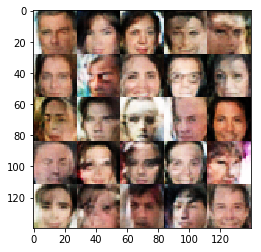

**********************************
Step: 5811
Epoch: 1/1
D Loss: 3.4775
G Loss: 0.0507
**********************************
Step: 5821
Epoch: 1/1
D Loss: 4.1298
G Loss: 0.0326
**********************************
Step: 5831
Epoch: 1/1
D Loss: 2.9350
G Loss: 0.1676
**********************************
Step: 5841
Epoch: 1/1
D Loss: 3.4905
G Loss: 0.0678
**********************************
Step: 5851
Epoch: 1/1
D Loss: 3.1961
G Loss: 0.0654
**********************************
Step: 5861
Epoch: 1/1
D Loss: 4.0208
G Loss: 0.0339
**********************************
Step: 5871
Epoch: 1/1
D Loss: 3.6694
G Loss: 0.0457
**********************************
Step: 5881
Epoch: 1/1
D Loss: 4.7017
G Loss: 0.0183
**********************************
Step: 5891
Epoch: 1/1
D Loss: 3.4424
G Loss: 0.0610
**********************************
Step: 5901
Epoch: 1/1
D Loss: 3.2799
G Loss: 0.0687
**********************************


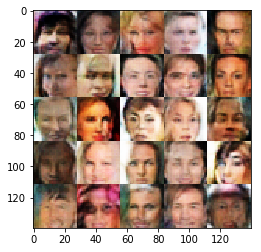

**********************************
Step: 5911
Epoch: 1/1
D Loss: 3.4192
G Loss: 0.0601
**********************************
Step: 5921
Epoch: 1/1
D Loss: 3.2670
G Loss: 0.1059
**********************************
Step: 5931
Epoch: 1/1
D Loss: 3.5800
G Loss: 0.0492
**********************************
Step: 5941
Epoch: 1/1
D Loss: 3.5461
G Loss: 0.0550
**********************************
Step: 5951
Epoch: 1/1
D Loss: 3.1805
G Loss: 0.0808
**********************************
Step: 5961
Epoch: 1/1
D Loss: 2.9814
G Loss: 0.0947
**********************************
Step: 5971
Epoch: 1/1
D Loss: 2.2030
G Loss: 0.2417
**********************************
Step: 5981
Epoch: 1/1
D Loss: 3.6233
G Loss: 0.0468
**********************************
Step: 5991
Epoch: 1/1
D Loss: 3.4767
G Loss: 0.0533
**********************************
Step: 6001
Epoch: 1/1
D Loss: 2.7477
G Loss: 0.1110
**********************************


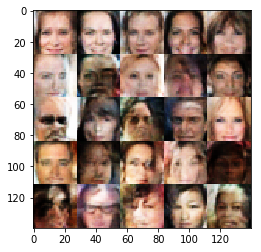

**********************************
Step: 6011
Epoch: 1/1
D Loss: 2.8531
G Loss: 0.1164
**********************************
Step: 6021
Epoch: 1/1
D Loss: 3.4922
G Loss: 0.0481
**********************************
Step: 6031
Epoch: 1/1
D Loss: 3.4991
G Loss: 0.0495
**********************************
Step: 6041
Epoch: 1/1
D Loss: 3.6338
G Loss: 0.0551
**********************************
Step: 6051
Epoch: 1/1
D Loss: 3.4948
G Loss: 0.0615
**********************************
Step: 6061
Epoch: 1/1
D Loss: 3.7554
G Loss: 0.0451
**********************************
Step: 6071
Epoch: 1/1
D Loss: 3.2427
G Loss: 0.0655
**********************************
Step: 6081
Epoch: 1/1
D Loss: 3.9809
G Loss: 0.0352
**********************************
Step: 6091
Epoch: 1/1
D Loss: 3.4939
G Loss: 0.0522
**********************************
Step: 6101
Epoch: 1/1
D Loss: 1.8992
G Loss: 0.3892
**********************************


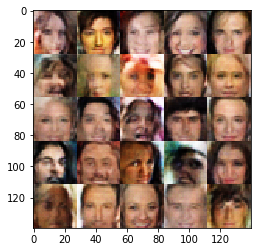

**********************************
Step: 6111
Epoch: 1/1
D Loss: 3.5745
G Loss: 0.0559
**********************************
Step: 6121
Epoch: 1/1
D Loss: 4.4271
G Loss: 0.0218
**********************************
Step: 6131
Epoch: 1/1
D Loss: 4.0642
G Loss: 0.0347
**********************************
Step: 6141
Epoch: 1/1
D Loss: 3.4138
G Loss: 0.0640
**********************************
Step: 6151
Epoch: 1/1
D Loss: 3.0363
G Loss: 0.1095
**********************************
Step: 6161
Epoch: 1/1
D Loss: 4.3764
G Loss: 0.0227
**********************************
Step: 6171
Epoch: 1/1
D Loss: 3.0167
G Loss: 0.0793
**********************************
Step: 6181
Epoch: 1/1
D Loss: 3.4804
G Loss: 0.0533
**********************************
Step: 6191
Epoch: 1/1
D Loss: 3.2693
G Loss: 0.1009
**********************************
Step: 6201
Epoch: 1/1
D Loss: 3.6551
G Loss: 0.1594
**********************************


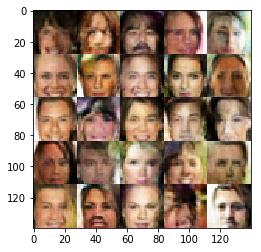

**********************************
Step: 6211
Epoch: 1/1
D Loss: 3.3501
G Loss: 0.0688
**********************************
Step: 6221
Epoch: 1/1
D Loss: 3.7204
G Loss: 0.0443
**********************************
Step: 6231
Epoch: 1/1
D Loss: 3.6434
G Loss: 0.0487
**********************************
Step: 6241
Epoch: 1/1
D Loss: 3.5620
G Loss: 0.0756
**********************************
Step: 6251
Epoch: 1/1
D Loss: 1.5361
G Loss: 0.4938
**********************************
Step: 6261
Epoch: 1/1
D Loss: 3.4409
G Loss: 0.0582
**********************************
Step: 6271
Epoch: 1/1
D Loss: 2.4633
G Loss: 0.2257
**********************************
Step: 6281
Epoch: 1/1
D Loss: 4.0270
G Loss: 0.0329
**********************************
Step: 6291
Epoch: 1/1
D Loss: 4.0687
G Loss: 0.0342
**********************************
Step: 6301
Epoch: 1/1
D Loss: 2.2463
G Loss: 0.2522
**********************************


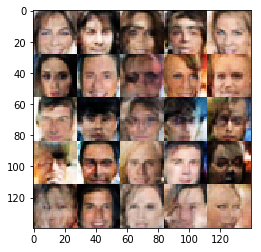

**********************************
Step: 6311
Epoch: 1/1
D Loss: 3.2566
G Loss: 0.0749
**********************************
Step: 6321
Epoch: 1/1
D Loss: 1.6290
G Loss: 0.6043
**********************************
Step: 6331
Epoch: 1/1
D Loss: 3.5617
G Loss: 0.0533


In [17]:
batch_size = 32
z_dim = 2000
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.